# Model Calibration using History Matching: Selecting features for calibration


Calibration of a SIR model using history matching. In this example, the user can configure the features (i.e., summary statistics) to use for calibration. More specifically, the user defines a set of features to be computed and used as potential targets for emulator fitting within history matching. The selection of the actual feature to use in each history matching iteration is based on a selection metric (which can also be configured by the user).


### Requirements

In addition to a set of basic python libraries, in this example we use the following components of phyloModels:

- **`phylomodels.models.sir_taoLeap_getIncidenceSampled`**: This is a basic SIR model that returns simulated incidence as time series. 

- **`phylomodels.calibration.init_historyMatching_poissonGlmBasis`**: This function runs a sequence of history matching iterations using a simplified configuration. This configuration uses a Poisson GLM basis for the history matching emulator (see [history_matching](https://github.com/InstituteforDiseaseModeling/history_matching) documentation for details on the configuration of history matching).

- **`phylomodels.calibration.cal_parameterSweep`**: This function computes a distance (i.e., error) metric for the model output (using a given set of input parameters) compared to some measurements or observations.

- **`phylomodels.features.features`**: This class is used for computing summary statistics.  

- **`phylomodels.visualization.parallelCoordinates`**: Parallel coordinates plot.


In [1]:
# Python libraries
import numpy
import pandas
import warnings
import matplotlib
import matplotlib.pyplot as plt1 # Fixing Pandas' issue (?)
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 250   # Improve the quality of figures in the notebook

# PhyloModels
from phylomodels.features.features                 import features 
from phylomodels.visualization.parallelCoordinates import parallelCoordinates

from phylomodels.models.sir_taoLeap_getIncidenceSampled             \
     import sir_taoLeap_getIncidenceSampled
from phylomodels.calibration.init_historyMatching_poissonGlmBasis   \
     import init_historyMatching_poissonGlmBasis
from phylomodels.calibration.cal_parameterSweep                     \
     import cal_parameterSweep

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


### Configuration parameters

We define a basic set of parameters for our example. These parameters define the ground truth (i.e., set of parameters that we expect to recover after calibration) and calibration processes.

#### Model parameters

In [2]:
# Model parameters (for generation of observations)
# This is the solution that we expect to recover after calibration
# In this model: 
# - beta and gamma are the transmission rate and the inverse of the
#   average transmission period, respectively; 
# - i0 and r0 are the initial number of individuals in the incidence
#   and recovered compartments, respectively;
# - N is the population size;
# - p is the sampling probability of incidence counts; and
# - nDays is the number of time steps in the simulation.
# 
xref_name = [ "beta", "gamma",    "N", "i0", "r0",   "p", "nDays" ]
xref_val  = [    2.2,     1.0,  10000,    5,    0,  0.05,     20  ]

# Model parameters (for calibration)
# These are lower and upper bounds for each of the model parameters;
# they are used as input for history matching. Note that in this case
# we are using the parameter "logN" and "logP" instead of "N" and "p".
# This is done to enforce a logarithmic search grid for these two
# parameters. The use of "logN" and "logP" is accepted by the model
# used in this example.
# 
Nmin =  100;   logNmin = numpy.log10(Nmin)
Nmax =  1e6;   logNmax = numpy.log10(Nmax)
Pmin = 1e-6;   logPmin = numpy.log10(Pmin)
Pmax =  1.0;   logPmax = numpy.log10(Pmax)

x_name = [ "beta", "gamma",   "logN", "i0", "r0",   "logP", "nDays" ]
x_min  = [    0.5,     0.5,  logNmin,    5,    0,  logPmin,      20 ]
x_max  = [      4,       4,  logNmax,    5,    0,  logPmax,      20 ]

#### Feature selection

The list of features should be defined as a tuple containing the names of the features to be used for calibration.

In [3]:
# First, let's see which features are available
dummyData = pandas.DataFrame( {"A": numpy.array([0,1,2])} )
dummyFeatures = features(dummyData, dummyData)
dummyFeatures.listActiveFeatures()

activeFeatures = 
  id 	 feature
------------------------------------------------------------------------
   0 	 series_derivative2_gaussianFit
   1 	 series_partialSum30
   2 	 series_derivative2_cauchyFit
   3 	 series_derivative_cauchyFit
   4 	 series_diff
   5 	 series_derivative_gaussianFit
   6 	 series_log10
   7 	 series_derivative
   8 	 series_sum_log10
   9 	 series_partialSum2
   10 	 series_partialSum10
   11 	 series_derivative2
   12 	 series_derivative_laplaceFit
   13 	 series_sum
   14 	 series
   15 	 series_diff_L2
   16 	 series_derivative2_laplaceFit
   17 	 series_partialSum7
   18 	 series_diff_L1
   19 	 series_partialSum15
   20 	 series_diff_Linf




In [4]:
# We can also check which metrics can be used for feature selection
dummyFeatures.listActiveStats()

activeStats = 
  id 	 statistic
------------------------------------------------------------------------
   0 	 qcd
   1 	 var
   2 	 rsd
   3 	 mean
   4 	 std
   5 	 skew
   6 	 fano




In [5]:
# Then we defined the tuple with features of interest
featurePool = ( "series",
                "series_diff_L1", 
                "series_diff_L2",
                "series_diff_Linf",
                "series_sum",
                "series_sum_Log10"
                "series_derivative_cauchyFit",
                "series_derivative2_cauchyFit"
               )

#### Calibration parameters

In [6]:
# History Matching (HM) configuration
hmParams = { "model_discrepancy"        : 2,      # standard dev. metric
             "observation_uncertainty"  : 10,     # ditto
             "max_rejection_rate"       : 99.5,   # exit condition (percentage)
             "max_iter"                 : 10,     # exit condition (# of HM waves)
             "n_candidates"             : 2000,   # grid size (number of parameter sets)
             "feature_selection_metric" : "fano", 
             "feature_pool"             : featurePool
            }

# Parameter sweep configuration
calParams = { "trials"      :  50,     # number of runs for each parameter set
              "cost_metric" : "L1"     # available metrics: "L1", "L2", "Linf"
             }
             
# Other parameters
jobId = "calibration_historyMatching_sir_results"  
seed  = 1000      # for random number generators

### Initialization

In [7]:
numpy.random.seed(seed)

### Generate observations/measurements

Here we generate the observations or measurements. In this case we simulate data using our model, but we could also load data from files, if already available. 

xref = 
    beta  gamma        N   i0   r0     p  nDays
0   2.2    1.0  10000.0  5.0  0.0  0.05   20.0 



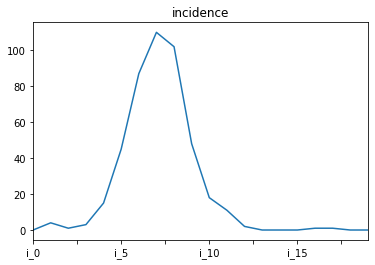

In [8]:
# Our model requires a pandas dataframe as its only input
xref = pandas.DataFrame( columns=xref_name )
xref.loc[0] = xref_val
print("xref = \n", xref, "\n")

# This is the call to our model
yref = sir_taoLeap_getIncidenceSampled( xref )

# The model returns a dataframe the incidence measurements
yref.transpose().plot( title="incidence", legend=False )


### Calibration initialization

Input arguments are formatted and passed to our history matching function. The calibration initialization function returns a set of non-unfeasable sets of parameters.

...History matching iteration  0  (max_iter =  10)
Welcome to IDM History Matching!
Found 2000 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1600 unique parameter configurations ( 1600  simulations including replicates)
--> Testing  with 400  unique parameter configurations ( 400 simulations including replicates)
Plotting
Autoinit GPU device name: Tesla P100-PCIE-12GB
Fitting the GPR


/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)



	LL: 2115.9934490062965 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [-652.69966075 -878.84477055  328.03367122 1108.18673731  343.63375458
  485.53668519]

	LL: 2115.9934490062965 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [-652.69966075 -878.84477055  328.03367122 1108.18673731  343.63375458
  485.53668519]

	LL: 1208.3864516784702 
	Theta: [2.94782793 0.16859464 0.08228664 0.05175585 0.08152723 0.07493337] 
	Deriv: [-259.43001636  118.71138816  119.97540288  242.21863392  118.76965617
  210.24583546]

	LL: 2532.6174915950032 
	Theta: [2.75634288e+01 6.06185619e-02 2.92658408e-02 6.42001774e-03
 2.92985742e-02 1.22433345e-02] 
	Deriv: [ 701.9344839    44.98371969 -476.28972122 -512.17038155 -471.21616688
 -509.00740861]

	LL: 865.9943442178273 
	Theta: [5.64313618 0.12525535 0.06094074 0.02822611 0.06056083 0.04427142] 
	Deriv: [-77.5079386  323.09669371 -57.10762944 -57.95690205  16.11664013
  67.42204174]

	LL: 529.2568409352557 
	Theta: [12.54780395  0.02077348  0.06687353  0.025

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/gpr.py:701: RuntimeWarning: invalid value encountered in log
  ll = np.sum(-0.5* np.log(sigma2) - np.divide(np.square(err), 2*sigma2))



	LL: nan 
	Theta: [1.92305538e+07 3.93866725e-02 1.73564504e+00 1.31129134e-01
 2.66673653e-01 7.23621248e-01] 
	Deriv: [ 1.62009381e+08  2.02977903e+07 -7.10067637e+08 -1.19273078e+09
 -1.02815140e+09 -7.94762118e+08]

	LL: nan 
	Theta: [4.69258683e+22 3.27719013e-01 5.91591031e+02 1.29354139e+00
 9.50819941e+00 9.52600801e+03] 
	Deriv: [ 6.87579035e+03  1.44982005e-12 -2.98204428e+02 -1.55457804e+03
 -9.76008449e+02 -6.13543982e+01]

	LL: nan 
	Theta: [4.68942175e+22 3.27705791e-01 5.91525339e+02 1.29348501e+00
 9.50755233e+00 9.52428749e+03] 
	Deriv: [ 1.99421316e+06  7.89917824e-10 -2.21881186e+05 -1.21562201e+06
 -1.93088256e+05 -1.41677059e+05]

	LL: nan 
	Theta: [4.68942175e+22 3.27705791e-01 5.91525339e+02 1.29348501e+00
 9.50755233e+00 9.52428749e+03] 
	Deriv: [ 1.99421316e+06  7.89917824e-10 -2.21881186e+05 -1.21562201e+06
 -1.93088256e+05 -1.41677059e+05]

	LL: 197.56342688370228 
	Theta: [2.73612957e+03 2.31905583e-02 4.03943613e-01 7.39910024e-02
 1.09131611e-01 6.7555607

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/gpr.py:701: RuntimeWarning: invalid value encountered in log
  ll = np.sum(-0.5* np.log(sigma2) - np.divide(np.square(err), 2*sigma2))



	LL: nan 
	Theta: [4.33677111e+04 2.70367974e-02 7.66445578e-01 1.21899008e-01
 3.56625602e-01 1.73238643e-01] 
	Deriv: [-3.25837657e+12  6.07026925e+12 -1.20101254e+12 -3.47119769e+12
 -1.74126775e+12 -2.36633603e+12]

	LL: nan 
	Theta: [3.26481290e+07 3.83276661e-02 4.79240540e+00 6.74566955e-01
 2.60163009e+01 2.28903954e+00] 
	Deriv: [-1.14864433e+08  1.15442818e+07 -9.50680094e+07 -1.97845823e+08
 -6.25766590e+07 -1.30338291e+08]

	LL: nan 
	Theta: [1.04863775e+19 1.54789281e-01 7.32558736e+03 6.32593366e+02
 7.36847590e+08 6.97729974e+04] 
	Deriv: [-1.15781815e+04 -8.94511390e-09  2.23522833e+02  3.44200128e+02
  1.35026047e+02  1.48861120e+02]

	LL: nan 
	Theta: [1.11607723e+65 4.11770199e+01 3.99942967e+16 4.89241081e+14
 4.74139513e+38 6.02315068e+22] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.43208660e+249 2.06210623e+011 3.55320706e+067 1.75031434e+062
 8.12868088e+157 3.34479202e+094] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.29


	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.79769313e+308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.79769313e+308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.79769313e+308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.79769313e+308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.79769313e+308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.79769313e+308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+30

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/gpr.py:701: RuntimeWarning: invalid value encountered in log
  ll = np.sum(-0.5* np.log(sigma2) - np.divide(np.square(err), 2*sigma2))



	LL: nan 
	Theta: [4.33677111e+04 2.70367974e-02 7.66445578e-01 1.21899008e-01
 3.56625602e-01 1.73238643e-01] 
	Deriv: [-3.25837657e+12  6.07026925e+12 -1.20101254e+12 -3.47119769e+12
 -1.74126775e+12 -2.36633603e+12]

	LL: nan 
	Theta: [2.27163970e+05 2.95015293e-02 1.21199096e+00 1.86963312e-01
 1.04224729e+00 3.30291124e-01] 
	Deriv: [-1.18621989e+09  3.00386309e+09 -1.42682649e+09 -2.60591252e+09
 -1.39044399e+09 -2.28585312e+09]

	LL: nan 
	Theta: [6.23283096e+06 3.51255467e-02 3.03064796e+00 4.39813787e-01
 8.90199385e+00 1.20060781e+00] 
	Deriv: [-1.26089602e+09  4.77309186e+08 -1.56579944e+09 -3.11735963e+09
 -1.50015734e+09 -1.73048977e+09]

	LL: nan 
	Theta: [4.69220682e+09 4.97943674e-02 1.89499347e+01 2.43384957e+00
 6.49412016e+02 1.58638898e+01] 
	Deriv: [-1190177.60664407     1864.76733823  -935514.57819253  -963010.49650794
  -737815.77108615  -846843.03605428]

	LL: nan 
	Theta: [2.65925963e+15 1.00067828e-01 7.40887333e+02 7.45321274e+01
 3.45610064e+06 2.76966172e+

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)



	LL: 5506.482570981587 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -304.9677559  -4615.80117552   560.9884446    685.62709968
   151.84713156   349.22480943]

	LL: 5506.482570981587 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -304.9677559  -4615.80117552   560.9884446    685.62709968
   151.84713156   349.22480943]

	LL: 2734.1443532543103 
	Theta: [2.13471245 0.2682089  0.08870025 0.08636842 0.09680648 0.09280734] 
	Deriv: [ -100.76087584 -1272.97689308   177.9368532    212.45162881
    38.79930547   112.98257686]

	LL: 3856.5840071236294 
	Theta: [ 2.96262499 16.85433989  0.04972409  0.04327535  0.08532878  0.06426587] 
	Deriv: [ 20.04089831 748.26665365  -7.00103949  -7.27819212  -7.25985543
  -6.85187767]

	LL: 2179.7788630634955 
	Theta: [2.3556161  0.93057755 0.0745426  0.07017555 0.09320455 0.08310555] 
	Deriv: [ -9.73178272 170.03385313  28.57190347  33.34223616  -4.18360464
  17.03101403]

	LL: 7480.428250298464 
	Theta: [1.64750487e+03 1.66707999e+00 2.89696235e-08 1.933


	LL: 1720.7478135327806 
	Theta: [2.97716168e+00 1.88983527e-03 8.32791425e-03 2.54991589e-03
 6.71613999e-02 2.88486051e-02] 
	Deriv: [ 0.99600083  4.42431706  6.37479863  7.22907355 -6.6616817  -2.96119732]

	LL: 1719.9856831184727 
	Theta: [2.92499525e+00 1.60303100e-03 8.14204261e-03 2.52991983e-03
 6.85052118e-02 2.90390411e-02] 
	Deriv: [-9.38813472  3.73039591  3.8252908   6.62913953  6.2194973   5.44963724]

	LL: 1722.4468680055993 
	Theta: [2.99923230e+00 1.31844430e-03 7.80409035e-03 2.43145504e-03
 6.79695758e-02 2.85059494e-02] 
	Deriv: [ 60.71091486   3.19913974 -50.01201365 -60.50527551 -25.99509103
 -33.02634566]

	LL: 1719.8438574582547 
	Theta: [2.93857529e+00 1.54616249e-03 8.07850130e-03 2.51142678e-03
 6.84059034e-02 2.89397744e-02] 
	Deriv: [ 4.22175767  3.63792142 -6.95139731 -6.81379258 -0.15323164 -2.19194548]

	LL: 1719.6594570566947 
	Theta: [2.94759162e+00 1.39300461e-03 8.03340058e-03 2.49996835e-03
 6.81647854e-02 2.88153572e-02] 
	Deriv: [ 15.00767767   3


	LL: 1716.1879936978441 
	Theta: [2.95220968e+00 2.18630341e-06 8.18687573e-03 2.52179380e-03
 6.82705676e-02 2.87994347e-02] 
	Deriv: [0.08198088 0.0050475  0.00411623 0.00805595 0.00354175 0.02234219]

	LL: 1716.1879936978441 
	Theta: [2.95220965e+00 2.18630340e-06 8.18687576e-03 2.52179379e-03
 6.82705678e-02 2.87994345e-02] 
	Deriv: [0.08198088 0.0050475  0.00411623 0.00805595 0.00354175 0.02234219]

	LL: 1716.1880675981124 
	Theta: [2.95220964e+00 2.18630340e-06 8.18687577e-03 2.52179378e-03
 6.82705678e-02 2.87994344e-02] 
	Deriv: [0.08195538 0.0050475  0.00445798 0.00808767 0.0037632  0.02253835]

	LL: 1716.1879936978441 
	Theta: [2.95220965e+00 2.18630340e-06 8.18687576e-03 2.52179379e-03
 6.82705678e-02 2.87994345e-02] 
	Deriv: [0.08198088 0.0050475  0.00411623 0.00805595 0.00354175 0.02234219]

	LL: 1716.1880675981124 
	Theta: [2.95220964e+00 2.18630340e-06 8.18687577e-03 2.52179378e-03
 6.82705678e-02 2.87994344e-02] 
	Deriv: [0.08195538 0.0050475  0.00445798 0.00808767 0.0

GPR evaluating test data
Plotting
Reading iteration 1 . cut history_matching_cut
Welcome to IDM History Matching!
Found 2022 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1618 unique parameter configurations ( 1618  simulations including replicates)
--> Testing  with 404  unique parameter configurations ( 404 simulations including replicates)
	 Desired Result: 1
	 Desired Result Var: 0
	 Discrepancy Var: 4
	 Imp Thresh: 3
Using Poisson family
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                 1618
Model:                            GLM   Df Residuals:                     1613
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4042.2
Date:                Mon, 18 Nov 2019

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Yglm'] = self.glm_all[cut].evaluate(plausible_candidates)
/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Mean_Estimate'] = plausible_candidates['Yglm'] + ret['Mean']
/home/rnunez/.conda/envs/phylom

Test plausibility: 0.2138075828552246
Merge plausibility (needed?): 0.0013530254364013672
Plausible candidates: New = 1795 , Tot = 1795
--------------------------------------------------------------------------------
LHS Sampling ( 285 ): 0.0010695457458496094
LHS Scaling: 0.001039743423461914
DataFrame: 0.0003151893615722656
Constraint: 2.384185791015625e-07
(285, 5)
Performing cut: iteration 1 , cut history_matching_cut
(268, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.09934091567993164
Merge plausibility (needed?): 0.0008807182312011719
Plausible candidates: New = 263 , Tot = 2058
Saving to: Candidates_for_iter2.hd5
Rejected 9.9% [227 / 2285]
...History matching iteration  2  (max_iter =  10)
Welcome to IDM History Matching!
Found 2058 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1646 unique parameter configurations ( 1646  simulations including replicates)
--> Testing  with 412  unique parameter configura

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)



	LL: 4451.273054073499 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -830.35951145 -3025.92230437   743.31744207    56.1814547
  1282.8928116    889.23047614]

	LL: 4451.273054073499 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -830.35951145 -3025.92230437   743.31744207    56.1814547
  1282.8928116    889.23047614]

	LL: 2356.4059260576128 
	Theta: [2.52745823 0.23465966 0.08109645 0.0984288  0.06965401 0.07782855] 
	Deriv: [-358.12982676 -692.54923076  283.16447012   30.67448493  460.55617214
  320.8968541 ]

	LL: 3142.975094070923 
	Theta: [1.14331011e+01 4.34511917e+00 2.45883757e-02 8.64926271e-02
 9.99992066e-03 2.01282429e-02] 
	Deriv: [128.02348085 618.83352271 -75.38220871 -61.60890534 -82.52172591
 -80.98254926]

	LL: 1897.9481806508898 
	Theta: [4.02384595 0.57674299 0.05614604 0.09458541 0.0383026  0.05130717] 
	Deriv: [-106.92716854  304.34685572   60.48771243   -8.33137879   83.02000859
   56.56040028]

	LL: 2312.169797527241 
	Theta: [2.36382230e+01 1.30654854e-01 1.74

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/gpr.py:701: RuntimeWarning: invalid value encountered in log
  ll = np.sum(-0.5* np.log(sigma2) - np.divide(np.square(err), 2*sigma2))



	LL: nan 
	Theta: [7.27123619e+03 1.51593739e-04 3.11662485e-01 2.29502971e-02
 2.42374681e-01 4.73019876e-02] 
	Deriv: [ 9.70366689e+07  5.30031334e+07 -6.85820337e+08 -1.11085376e+09
 -6.97539223e+08 -1.03312331e+09]

	LL: nan 
	Theta: [6.57861326e+08 2.69825039e-11 4.41014367e+01 9.14796776e-02
 1.26313447e+00 2.22562566e-02] 
	Deriv: [ 1.46776360e+06  5.88658173e-06 -4.46323121e+06 -1.90670143e+07
 -9.57124617e+06 -2.29681987e+07]

	LL: nan 
	Theta: [4.40797145e+28 2.70823395e-38 1.76817632e+10 2.30924431e+01
 9.31748998e+02 1.09079475e-03] 
	Deriv: [-5.47539070e+04 -4.20984079e-54  3.33028208e+01  5.19581072e+04
  3.40561267e+04  3.58855230e+05]

	LL: nan 
	Theta: [8.88497969e+107 2.74853895e-146 4.56895524e+044 9.37671913e+010
 2.75864821e+014 6.29370983e-009] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 2.03695875e+182 2.54903037e+049
 2.11975599e+060 6.97527646e-030] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+30


	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+30

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/gpr.py:701: RuntimeWarning: invalid value encountered in log
  ll = np.sum(-0.5* np.log(sigma2) - np.divide(np.square(err), 2*sigma2))



	LL: nan 
	Theta: [6.75938515e+03 1.67436640e-04 3.01945526e-01 2.27482183e-02
 2.39828995e-01 4.75306284e-02] 
	Deriv: [ 1.30877701e+08  8.59471853e+07 -9.26063797e+08 -1.40462259e+09
 -8.53260968e+08 -1.19562713e+09]

	LL: nan 
	Theta: [3.85629005e+05 6.79582942e-07 1.74589251e+00 3.71310672e-02
 4.30472442e-01 3.63877460e-02] 
	Deriv: [ 3.32657750e+08  2.05352481e+04 -1.19927665e+09 -2.89901917e+09
 -1.85049213e+09 -2.78077235e+09]

	LL: nan 
	Theta: [1.25514728e+09 1.11950596e-11 5.83707549e+01 9.89276105e-02
 1.38686021e+00 2.13264394e-02] 
	Deriv: [ 1.77683373e+06  1.05650116e-06 -3.17167673e+06 -1.38106251e+07
 -6.68218760e+06 -1.61311417e+07]

	LL: nan 
	Theta: [1.32967248e+16 3.03804561e-21 6.52455545e+04 7.02227277e-01
 1.43948569e+01 7.32562606e-03] 
	Deriv: [ 1.17799561e+05  6.52249087e-25 -1.78109606e+04 -1.20136795e+05
 -3.22617243e+04 -2.11279138e+05]

	LL: nan 
	Theta: [4.08525983e+12 1.84420990e-16 1.95152050e+03 2.63570990e-01
 4.46807053e+00 1.24991808e-02] 
	Deriv:


	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+30


	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 2.22507386e-308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 2.22507386e-308 1.79769313e+308 1.79769313e+30

(2000, 5)
Performing cut: iteration 1 , cut history_matching_cut
(1850, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.2574489116668701
Merge plausibility (needed?): 0.0009434223175048828
Plausible candidates: New = 1801 , Tot = 1801
--------------------------------------------------------------------------------
LHS Sampling ( 276 ): 0.0006241798400878906
LHS Scaling: 0.0008356571197509766
DataFrame: 0.00019216537475585938
Constraint: 4.76837158203125e-07
(276, 5)
Performing cut: iteration 2 , cut history_matching_cut


/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Yglm'] = self.glm_all[cut].evaluate(plausible_candidates)
/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Mean_Estimate'] = plausible_candidates['Yglm'] + ret['Mean']
/home/rnunez/.conda/envs/phylom

(276, 5)
Performing cut: iteration 1 , cut history_matching_cut
(258, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.11680102348327637
Merge plausibility (needed?): 0.0007071495056152344
Plausible candidates: New = 253 , Tot = 2054
Saving to: Candidates_for_iter3.hd5
Rejected 9.8% [222 / 2276]
...History matching iteration  3  (max_iter =  10)
Welcome to IDM History Matching!
Found 2054 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1643 unique parameter configurations ( 1643  simulations including replicates)
--> Testing  with 411  unique parameter configurations ( 411 simulations including replicates)
Plotting
Autoinit GPU device name: Tesla P100-PCIE-12GB
Fitting the GPR


/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)



	LL: 5338.2843976766135 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -917.710708   -3828.1729468    937.03786137  1531.28551626
   862.90468462   431.75618902]

	LL: 5338.2843976766135 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -917.710708   -3828.1729468    937.03786137  1531.28551626
   862.90468462   431.75618902]

	LL: 2694.3947126328926 
	Theta: [2.4651138  0.23921898 0.08077568 0.07054726 0.0821516  0.09063125] 
	Deriv: [ -376.70291762 -1001.4325275    323.07893982   590.9433187
   316.74371996   154.05450715]

	LL: 3201.799948282115 
	Theta: [7.92693042 5.3373352  0.02966351 0.01129057 0.03076727 0.05621189] 
	Deriv: [ 87.02419436 660.44861814 -45.72028867 -47.08694419 -49.1226553
 -44.08414128]

	LL: 2042.1212309212242 
	Theta: [3.67839253 0.69324091 0.0573064  0.03765326 0.05867617 0.07694723] 
	Deriv: [-98.61274226 281.56447698  50.36844481 142.2316203   58.44807835
  21.11638485]

	LL: 3116.7051367648514 
	Theta: [2.75469767e+01 1.02685742e-01 1.60947080e-02 1.88967886e

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/gpr.py:701: RuntimeWarning: invalid value encountered in log
  ll = np.sum(-0.5* np.log(sigma2) - np.divide(np.square(err), 2*sigma2))



	LL: nan 
	Theta: [3.97225335e+04 1.01030118e-02 1.66238639e-01 3.34865461e-02
 4.03826173e-01 2.09291102e-01] 
	Deriv: [-5.82206914e+09  7.32608217e+09 -6.83963639e+09 -1.09117856e+10
 -4.83100419e+09 -6.55035255e+09]

	LL: nan 
	Theta: [1.12326492e+12 6.12817703e-01 1.47708477e+00 6.79866363e-02
 1.77700575e+00 1.88086426e+02] 
	Deriv: [-3.25665604e+04 -3.30508093e+00  1.77148115e+05  3.13502069e+05
  1.29328168e+05  5.05298068e+04]

	LL: nan 
	Theta: [1.12318667e+12 6.12807488e-01 1.47707167e+00 6.79864408e-02
 1.77699506e+00 1.88081232e+02] 
	Deriv: [-9.66572495e+03  6.76486214e-01 -2.63355571e+04 -7.92912881e+04
 -2.83465284e+04 -9.80255054e+03]

	LL: nan 
	Theta: [1.12321786e+12 6.12811560e-01 1.47707690e+00 6.79865188e-02
 1.77699932e+00 1.88083302e+02] 
	Deriv: [ 3.80020420e+04  1.88008287e+00 -7.97640198e+04 -1.99425681e+05
 -7.76890772e+04 -3.11824222e+04]

	LL: nan 
	Theta: [1.12321713e+12 6.12811464e-01 1.47707677e+00 6.79865169e-02
 1.77699922e+00 1.88083254e+02] 
	Deriv:

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/gpr.py:701: RuntimeWarning: invalid value encountered in log
  ll = np.sum(-0.5* np.log(sigma2) - np.divide(np.square(err), 2*sigma2))



	LL: nan 
	Theta: [1.48573090e+04 7.16342989e-03 1.50820293e-01 5.40726087e-02
 4.79355708e-01 1.98643356e-01] 
	Deriv: [-4.68332385e+10  7.37980586e+10 -4.47979066e+10 -5.87281626e+10
 -2.35593564e+10 -3.46850306e+10]

	LL: nan 
	Theta: [5.79301194e+07 3.35550840e-02 4.83117450e-01 6.08320175e-01
 2.72995068e+00 2.03201111e+01] 
	Deriv: [ 8.46457853e+09  2.75793911e+08 -1.66811363e+10 -1.42234426e+10
 -9.94316979e+09 -4.54017259e+09]

	LL: nan 
	Theta: [1.33894118e+22 1.61550234e+01 5.08656393e+01 9.74432610e+03
 2.87172200e+03 2.22502150e+09] 
	Deriv: [-7.73937203e+04 -1.45649099e-08  7.44949018e+03  4.51453007e+03
  5.53949123e+03  2.98398557e+02]

	LL: nan 
	Theta: [3.82111230e+79 8.67969847e+11 6.25045506e+09 6.41549497e+20
 3.51635545e+15 3.19865019e+41] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 7.23257297e+054 1.42514862e+042 1.20543447e+088
 7.90486155e+063 1.36614529e+170] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 3.48


	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.79769313e+308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.79769313e+308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.79769313e+308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.79769313e+308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.79769313e+308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.79769313e+308] 
	Deriv: [nan nan nan nan nan nan]

	LL: nan 
	Theta: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+30

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/gpr.py:701: RuntimeWarning: invalid value encountered in log
  ll = np.sum(-0.5* np.log(sigma2) - np.divide(np.square(err), 2*sigma2))



	LL: nan 
	Theta: [1.48573090e+04 7.16342989e-03 1.50820293e-01 5.40726087e-02
 4.79355708e-01 1.98643356e-01] 
	Deriv: [-4.68332385e+10  7.37980586e+10 -4.47979066e+10 -5.87281626e+10
 -2.35593564e+10 -3.46850306e+10]

	LL: nan 
	Theta: [1.17403548e+05 1.05385375e-02 2.01770660e-01 9.90298330e-02
 7.40512046e-01 6.31738076e-01] 
	Deriv: [-1.09475349e+11  1.98254214e+11 -2.94766203e+11 -4.46131182e+11
 -2.21488255e+11 -2.54398565e+11]

	LL: nan 
	Theta: [7.33100232e+06 2.28086196e-02 3.61122450e-01 3.32157066e-01
 1.76717914e+00 6.38944403e+00] 
	Deriv: [ 3.70701458e+11  3.76700676e+10 -8.60979568e+11 -8.67596892e+11
 -3.61739222e+11 -2.79105865e+11]

	LL: nan 
	Theta: [2.85843042e+10 1.06840600e-01 1.15677111e+00 3.73678743e+00
 1.00641587e+01 6.53604605e+02] 
	Deriv: [-2.50087982e+05  3.03766116e+01 -4.99615900e+04 -4.29447209e+04
 -6.80898431e+04 -2.16283045e+04]

	LL: nan 
	Theta: [4.34566419e+17 2.34428791e+00 1.18695246e+01 4.72942331e+02
 3.26415875e+02 6.83941837e+06] 
	Deriv:

Welcome to IDM History Matching!
Found 2022 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1618 unique parameter configurations ( 1618  simulations including replicates)
--> Testing  with 404  unique parameter configurations ( 404 simulations including replicates)
	 Desired Result: 1
	 Desired Result Var: 0
	 Discrepancy Var: 4
	 Imp Thresh: 3
Using Poisson family
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                 1618
Model:                            GLM   Df Residuals:                     1613
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4042.2
Date:                Mon, 18 Nov 2019   Deviance:                       7854.1
Time:                        21:53:41  

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Yglm'] = self.glm_all[cut].evaluate(plausible_candidates)
/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Mean_Estimate'] = plausible_candidates['Yglm'] + ret['Mean']
/home/rnunez/.conda/envs/phylom

Test plausibility: 0.33692240715026855
Merge plausibility (needed?): 0.001416921615600586
Plausible candidates: New = 920 , Tot = 920
--------------------------------------------------------------------------------
LHS Sampling ( 2932 ): 0.0033617019653320312
LHS Scaling: 0.0017240047454833984
DataFrame: 0.00029087066650390625
Constraint: 4.76837158203125e-07
(2932, 5)
Performing cut: iteration 3 , cut history_matching_cut
(1621, 5)
Performing cut: iteration 2 , cut history_matching_cut
(1621, 5)
Performing cut: iteration 1 , cut history_matching_cut
(1427, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.4058516025543213
Merge plausibility (needed?): 0.0012426376342773438
Plausible candidates: New = 1390 , Tot = 2310
Saving to: Candidates_for_iter4.hd5
Rejected 53.2% [2622 / 4932]
...History matching iteration  4  (max_iter =  10)
Welcome to IDM History Matching!
Found 2310 unique parameter configurations, each of which is repeated 1 time(s).
--> Training

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)



	LL: 5690.062588020808 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -391.54668812 -4641.26130598   313.97754618   299.94600491
   311.45777974   585.74206798]

	LL: 5690.062588020808 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -391.54668812 -4641.26130598   313.97754618   299.94600491
   311.45777974   585.74206798]

	LL: 2932.983344704722 
	Theta: [2.17460557 0.26970343 0.09350846 0.09378935 0.09355884 0.08823091] 
	Deriv: [ -136.1878473  -1248.02386857    88.41346869    92.11314568
    73.40575368   183.79957281]

	LL: 4511.769239068292 
	Theta: [ 3.46154635 19.09857462  0.06914864  0.068486    0.07282249  0.04711398] 
	Deriv: [ 20.24586891 862.49561967  -8.03218544  -7.69237162  -8.07923263
  -7.91803732]

	LL: 2437.3915703860594 
	Theta: [2.4720221  0.8730974  0.08604162 0.08600008 0.08731271 0.074214  ] 
	Deriv: [-25.81457131 195.72372131   8.17278938  11.5898195    0.56424652
  33.17048792]

	LL: 36989.39467136816 
	Theta: [3.86736688e+16 2.13883099e+04 1.91305461e-09 8.64639


	LL: 1474.6107400190572 
	Theta: [6.24986775e+01 1.22206950e-02 7.83050739e-02 2.30160937e-01
 6.38495996e-02 1.68703841e-03] 
	Deriv: [ 158.14731148   56.26444014 -192.99838455 -166.05842176 -186.65520451
 -341.08830048]

	LL: 1438.6740610545662 
	Theta: [5.77347731e+01 1.22931905e-02 7.92855979e-02 2.32720061e-01
 6.53374731e-02 1.94408114e-03] 
	Deriv: [-10.43949057  18.89453432 -37.81169112 -31.24274894 -29.15977548
   4.28064677]

	LL: 1436.316421113537 
	Theta: [5.97402285e+01 1.19641219e-02 8.31991585e-02 2.42124324e-01
 6.75815985e-02 1.86497233e-03] 
	Deriv: [-35.93468166  14.82265353   3.54873604  -2.06283295  24.71231751
 -28.96753782]

	LL: 1432.3964840955955 
	Theta: [6.62422149e+01 1.12954733e-02 8.73465845e-02 2.54262283e-01
 6.71979772e-02 1.87326609e-03] 
	Deriv: [-37.88061509   7.34360403  21.2210896    9.07892626  11.37437795
 -26.52277702]

	LL: 1429.7756614679936 
	Theta: [7.95168938e+01 1.02034557e-02 9.51913554e-02 2.77229561e-01
 6.65250724e-02 1.88801944e-03] 

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/gpr.py:701: RuntimeWarning: invalid value encountered in log
  ll = np.sum(-0.5* np.log(sigma2) - np.divide(np.square(err), 2*sigma2))



	LL: nan 
	Theta: [4.32405835e+04 1.05077432e-02 3.65045595e-01 5.26581567e-01
 2.35179548e-01 3.98869646e-03] 
	Deriv: [-338596.75648154  670966.68184207 -482560.21699662 -462345.477989
 -605754.6147068  -765828.09246596]

	LL: nan 
	Theta: [2.31229506e+08 1.23026590e-03 1.35189331e+00 7.85043669e-01
 9.91686714e-01 7.66052067e-03] 
	Deriv: [ 1.70613847e+10  2.14233040e+06 -3.12783153e+10 -3.83300434e+10
 -3.58067172e+10 -7.19402432e+10]

	LL: nan 
	Theta: [1.89081949e+23 2.31183664e-07 2.54286702e+02 3.87798805e+00
 3.13526508e+02 1.04223942e-01] 
	Deriv: [ 1.74418498e+04  1.21525088e-18 -4.17350166e+03 -1.01794646e+04
 -4.97815615e+03 -1.58653964e+04]

	LL: nan 
	Theta: [1.88985749e+23 2.31213061e-07 2.54266966e+02 3.87789625e+00
 3.13499762e+02 1.04219910e-01] 
	Deriv: [-2.42509293e+03 -4.92402198e-19 -2.03892769e+03 -4.79386115e+03
 -7.86675301e-01  1.01432518e+04]

	LL: nan 
	Theta: [1.88998520e+23 2.31209158e-07 2.54269587e+02 3.87790844e+00
 3.13503313e+02 1.04220445e-01] 
	De

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/gpr.py:701: RuntimeWarning: invalid value encountered in log
  ll = np.sum(-0.5* np.log(sigma2) - np.divide(np.square(err), 2*sigma2))



	LL: nan 
	Theta: [4.32405835e+04 1.05077432e-02 3.65045595e-01 5.26581567e-01
 2.35179548e-01 3.98869646e-03] 
	Deriv: [-338596.75648154  670966.68184207 -482560.21699662 -462345.477989
 -605754.6147068  -765828.09246596]

	LL: nan 
	Theta: [3.69768126e+05 6.14655587e-03 5.06402614e-01 5.81865615e-01
 3.37010388e-01 4.69556452e-03] 
	Deriv: [ 2.03366934e+10  1.30078330e+10 -1.66900095e+11 -1.48303234e+11
 -1.70886425e+11 -3.51086642e+11]

	LL: nan 
	Theta: [2.70399151e+07 2.10318077e-03 9.74526364e-01 7.10455327e-01
 6.92039302e-01 6.50730951e-03] 
	Deriv: [ 1.78060207e+08  3.64145048e+05 -4.58119294e+08 -5.14042013e+08
 -5.05600940e+08 -1.11342324e+09]

	LL: nan 
	Theta: [1.44596250e+11 2.46244274e-04 3.60901677e+00 1.05916821e+00
 2.91813717e+00 1.24976617e-02] 
	Deriv: [-3.73297380e+05  7.63496790e-02 -1.51458296e+06 -1.88437071e+06
 -1.90652161e+06 -5.36766893e+06]

	LL: nan 
	Theta: [4.13485647e+18 3.37555523e-06 4.94970727e+01 2.35408025e+00
 5.18866447e+01 4.60981363e-02] 
	De

Welcome to IDM History Matching!
Found 2058 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1646 unique parameter configurations ( 1646  simulations including replicates)
--> Testing  with 412  unique parameter configurations ( 412 simulations including replicates)
	 Desired Result: 15
	 Desired Result Var: 0
	 Discrepancy Var: 4
	 Imp Thresh: 3
Using Poisson family
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                 1646
Model:                            GLM   Df Residuals:                     1641
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10918.
Date:                Mon, 18 Nov 2019   Deviance:                       20789.
Time:                        21:57:04 

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Yglm'] = self.glm_all[cut].evaluate(plausible_candidates)
/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Mean_Estimate'] = plausible_candidates['Yglm'] + ret['Mean']
/home/rnunez/.conda/envs/phylom

(895, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.40761804580688477
Merge plausibility (needed?): 0.0012159347534179688
Plausible candidates: New = 877 , Tot = 877
--------------------------------------------------------------------------------
LHS Sampling ( 3198 ): 0.003624439239501953
LHS Scaling: 0.0015382766723632812
DataFrame: 0.0002815723419189453
Constraint: 7.152557373046875e-07
(3198, 5)
Performing cut: iteration 4 , cut history_matching_cut
(2938, 5)
Performing cut: iteration 3 , cut history_matching_cut
(1600, 5)
Performing cut: iteration 2 , cut history_matching_cut
(1600, 5)
Performing cut: iteration 1 , cut history_matching_cut
(1465, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.5963728427886963
Merge plausibility (needed?): 0.0016188621520996094
Plausible candidates: New = 1429 , Tot = 2306
Saving to: Candidates_for_iter5.hd5
Rejected 55.6% [2892 / 5198]
...History matching iteration  5  (max_iter =  1

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)



	LL: 2785.1892581006196 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -603.35074383 -1524.90516377   349.64711498   268.35243284
   316.34694288   760.50016946]

	LL: 2785.1892581006196 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -603.35074383 -1524.90516377   349.64711498   268.35243284
   316.34694288   760.50016946]

	LL: 1784.351362605796 
	Theta: [2.76219688 0.2261533  0.08293514 0.08662281 0.08442632 0.06656597] 
	Deriv: [-251.68828546 -103.60944039  127.34905458   82.15417182   87.02593922
  276.52750828]

	LL: 3389.019240216385 
	Theta: [4.58731508e+01 7.19035837e-01 2.00119811e-02 3.46186358e-02
 3.19547129e-02 3.03749832e-03] 
	Deriv: [ 614.22010959  267.26210812 -386.5005116  -367.74303446 -379.02049111
 -453.84741957]

	LL: 1537.1760084995294 
	Theta: [5.65969951 0.30384373 0.05769078 0.06853969 0.06588059 0.03026688] 
	Deriv: [-79.66299944 392.5845848   25.73440594  -1.73272904 -27.64112164
  56.12798527]

	LL: 1316.9381201709853 
	Theta: [1.50434757e+01 1.21436050e-01 


	LL: 927.4267782261796 
	Theta: [4.76122490e+02 5.22367117e-02 1.93378986e-01 2.91091874e-01
 4.63251465e-02 1.83405136e-02] 
	Deriv: [  1.99602222 -14.44870207  -4.38144976   0.34022544  -3.63020711
  -6.7413124 ]

	LL: 930.9751857041563 
	Theta: [2.94634674e+03 5.55166356e-02 2.74307204e-01 3.46384188e-01
 7.14224020e-02 2.55070636e-02] 
	Deriv: [-13.81120034 -45.7518975   48.96458588   3.94972803  38.46186869
   9.21171834]

	LL: 926.6870055909893 
	Theta: [6.92396044e+02 5.28944036e-02 2.07780133e-01 3.01681131e-01
 5.06345695e-02 1.96265331e-02] 
	Deriv: [ -0.6011075  -17.66727844   3.09807436   1.66001645   1.81750058
  -5.28577586]

	LL: 927.3092898361026 
	Theta: [7.35185122e+02 5.30004832e-02 2.10183728e-01 3.03412160e-01
 5.13609227e-02 1.98406738e-02] 
	Deriv: [  0.1503351  -20.00997357   5.08781618   2.67854534   3.33968435
  -3.93543966]

	LL: 927.2989935163428 
	Theta: [6.93025598e+02 5.28960098e-02 2.07816356e-01 3.01707292e-01
 5.06455012e-02 1.96297613e-02] 
	Deriv: [


	LL: 926.7917595642243 
	Theta: [8.18187143e+02 5.77395707e-02 2.11193006e-01 3.04572685e-01
 5.22075568e-02 2.07376491e-02] 
	Deriv: [  6.36707951  29.96088764  -7.32926525 -11.47886876 -14.92560212
 -12.15446477]

	LL: 926.4805472501241 
	Theta: [8.18189146e+02 5.77396463e-02 2.11193056e-01 3.04572727e-01
 5.22075801e-02 2.07376660e-02] 
	Deriv: [  5.79414828  30.50718118  -7.35290173 -11.37045093 -15.57846895
 -12.93363903]

	LL: 927.1477219670268 
	Theta: [8.18187824e+02 5.77395964e-02 2.11193023e-01 3.04572699e-01
 5.22075647e-02 2.07376548e-02] 
	Deriv: [  6.46361332  29.24975833  -7.19650825 -10.85275828 -14.43973002
 -12.8893979 ]

	LL: 926.4805472501241 
	Theta: [8.18189146e+02 5.77396463e-02 2.11193056e-01 3.04572727e-01
 5.22075801e-02 2.07376660e-02] 
	Deriv: [  5.79414828  30.50718118  -7.35290173 -11.37045093 -15.57846895
 -12.93363903]

	LL: 927.4806744315097 
	Theta: [8.18188273e+02 5.77396134e-02 2.11193034e-01 3.04572709e-01
 5.22075699e-02 2.07376586e-02] 
	Deriv: [


	LL: 926.9579381952142 
	Theta: [8.16919391e+02 5.76917645e-02 2.11161620e-01 3.04546034e-01
 5.21928041e-02 2.07269548e-02] 
	Deriv: [  6.14699692  28.88306822  -7.42213892 -11.18815886 -15.13101053
 -12.91196243]

	LL: 927.4522959597064 
	Theta: [8.18164567e+02 5.77387197e-02 2.11192447e-01 3.04572211e-01
 5.22072942e-02 2.07374588e-02] 
	Deriv: [  6.02574499  28.71054986  -7.33427632 -11.31111919 -14.17821034
 -12.49639181]

	LL: 926.4805472501241 
	Theta: [8.18189142e+02 5.77396461e-02 2.11193055e-01 3.04572727e-01
 5.22075800e-02 2.07376660e-02] 
	Deriv: [  5.79414825  30.5071811   -7.35290173 -11.37045093 -15.57846894
 -12.93363901]

	LL: 926.4805472501241 
	Theta: [8.18189144e+02 5.77396462e-02 2.11193056e-01 3.04572727e-01
 5.22075801e-02 2.07376660e-02] 
	Deriv: [  5.79414827  30.50718115  -7.35290173 -11.37045093 -15.57846895
 -12.93363902]

	LL: 926.4805472501241 
	Theta: [8.18189146e+02 5.77396463e-02 2.11193056e-01 3.04572727e-01
 5.22075801e-02 2.07376660e-02] 
	Deriv: [

Reading iteration 2 . cut history_matching_cut
Welcome to IDM History Matching!
Found 2058 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1646 unique parameter configurations ( 1646  simulations including replicates)
--> Testing  with 412  unique parameter configurations ( 412 simulations including replicates)
	 Desired Result: 15
	 Desired Result Var: 0
	 Discrepancy Var: 4
	 Imp Thresh: 3
Using Poisson family
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                 1646
Model:                            GLM   Df Residuals:                     1641
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10918.
Date:                Mon, 18 Nov 2019   Deviance:                     

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Yglm'] = self.glm_all[cut].evaluate(plausible_candidates)
/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Mean_Estimate'] = plausible_candidates['Yglm'] + ret['Mean']
/home/rnunez/.conda/envs/phylom

(1764, 5)
Performing cut: iteration 3 , cut history_matching_cut
(961, 5)
Performing cut: iteration 2 , cut history_matching_cut
(961, 5)
Performing cut: iteration 1 , cut history_matching_cut
(884, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.664691686630249
Merge plausibility (needed?): 0.0014367103576660156
Plausible candidates: New = 867 , Tot = 867
--------------------------------------------------------------------------------
LHS Sampling ( 3263 ): 0.005388975143432617
LHS Scaling: 0.002360820770263672
DataFrame: 0.0005788803100585938
Constraint: 1.1920928955078125e-06
(3263, 5)
Performing cut: iteration 5 , cut history_matching_cut
(3068, 5)
Performing cut: iteration 4 , cut history_matching_cut
(2886, 5)
Performing cut: iteration 3 , cut history_matching_cut
(1598, 5)
Performing cut: iteration 2 , cut history_matching_cut
(1598, 5)
Performing cut: iteration 1 , cut history_matching_cut
(1462, 5)
Performing cut: iteration 0 , cut history_matchi

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)



	LL: 5870.08010184691 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -749.21827869 -4468.48162536  1098.68038893   665.39152113
   842.36219777   624.82551062]

	LL: 5870.08010184691 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -749.21827869 -4468.48162536  1098.68038893   665.39152113
   842.36219777   624.82551062]

	LL: 3016.8018863298785 
	Theta: [2.33961313 0.25482691 0.07945388 0.08699753 0.08383356 0.08773945] 
	Deriv: [ -283.20921479 -1225.77979134   360.50855638   232.05187971
   278.31725027   194.42183593]

	LL: 4069.9445003813416 
	Theta: [ 5.57001115 10.88232798  0.02633802  0.04274074  0.03574481  0.04837086] 
	Deriv: [ 46.76498537 809.30691469 -21.02691633 -18.51429241 -20.95308413
 -19.98411466]

	LL: 2415.2813753188952 
	Theta: [3.05587791 0.80961595 0.05655412 0.06989838 0.06448067 0.07304105] 
	Deriv: [-65.90534817 220.57537179  65.38193397  45.45246933  50.4974844
  29.05388114]

	LL: 5729.291924523497 
	Theta: [1.13654733e+02 1.41008384e-01 1.07129081e-03 4.846054


	LL: 142.35375328798682 
	Theta: [1.68146716e+02 5.48623140e-07 2.04390316e-01 2.98539600e-02
 1.21234705e-02 8.78064081e-02] 
	Deriv: [-1.07304603e+02 -9.22296411e-03  1.14135527e+02  5.52194362e+01
  5.15094331e+00  6.69877923e+01]

	LL: 134.44733755292623 
	Theta: [1.73225113e+02 5.48621322e-07 1.99151316e-01 3.12515707e-02
 1.19997138e-02 8.63820764e-02] 
	Deriv: [-6.98780283e+01  7.99273875e-03  4.24602848e+01  5.18656497e+01
 -1.07431965e+02 -4.64159873e+00]

	LL: 137.11886986222726 
	Theta: [2.08192502e+02 5.48609909e-07 1.74539734e-01 3.24348134e-02
 1.37937389e-02 8.34355114e-02] 
	Deriv: [ 6.74296061e+00  4.60508621e-02 -1.23794077e+02 -9.18926924e+01
  5.60887048e+01 -1.74573140e+02]

	LL: 132.01779139198902 
	Theta: [1.87177154e+02 5.48616514e-07 1.88385647e-01 3.17447070e-02
 1.27251751e-02 8.51282334e-02] 
	Deriv: [-3.57088647e+01  1.78383700e-02 -2.28568892e+01 -7.51701209e+00
 -3.96884379e+01 -7.64624675e+01]

	LL: 126.6895045338265 
	Theta: [1.92367402e+02 5.48611104e


	LL: 63.53979257665151 
	Theta: [6.16305424e+02 5.48289895e-07 1.96600536e-01 3.85734310e-02
 1.40196266e-02 1.29532511e-01] 
	Deriv: [-43.14884064   0.14409186 -15.71519837  39.16014539 -60.08104228
  25.49909643]

	LL: 63.53979257665151 
	Theta: [6.16305424e+02 5.48289895e-07 1.96600536e-01 3.85734310e-02
 1.40196266e-02 1.29532511e-01] 
	Deriv: [-43.14884064   0.14409186 -15.71519837  39.16014539 -60.08104228
  25.49909643]

	LL: 63.53979257665151 
	Theta: [6.16305424e+02 5.48289895e-07 1.96600536e-01 3.85734310e-02
 1.40196266e-02 1.29532511e-01] 
	Deriv: [-43.14884064   0.14409186 -15.71519837  39.16014539 -60.08104228
  25.49909643]

	LL: 63.53979257665151 
	Theta: [6.16305424e+02 5.48289895e-07 1.96600536e-01 3.85734310e-02
 1.40196266e-02 1.29532511e-01] 
	Deriv: [-43.14884064   0.14409186 -15.71519837  39.16014539 -60.08104228
  25.49909643]

	LL: 63.53979257665151 
	Theta: [6.16305424e+02 5.48289895e-07 1.96600536e-01 3.85734310e-02
 1.40196266e-02 1.29532511e-01] 
	Deriv: [


	LL: 63.53979257665151 
	Theta: [6.16305424e+02 5.48289895e-07 1.96600536e-01 3.85734310e-02
 1.40196266e-02 1.29532511e-01] 
	Deriv: [-43.14884064   0.14409186 -15.71519837  39.16014539 -60.08104228
  25.49909643]

	LL: 63.53979257665151 
	Theta: [6.16305424e+02 5.48289895e-07 1.96600536e-01 3.85734310e-02
 1.40196266e-02 1.29532511e-01] 
	Deriv: [-43.14884064   0.14409186 -15.71519837  39.16014539 -60.08104228
  25.49909643]

	LL: 63.53979257665151 
	Theta: [6.16305424e+02 5.48289895e-07 1.96600536e-01 3.85734310e-02
 1.40196266e-02 1.29532511e-01] 
	Deriv: [-43.14884064   0.14409186 -15.71519837  39.16014539 -60.08104228
  25.49909643]

	LL: 63.53979257665151 
	Theta: [6.16305424e+02 5.48289895e-07 1.96600536e-01 3.85734310e-02
 1.40196266e-02 1.29532511e-01] 
	Deriv: [-43.14884064   0.14409186 -15.71519837  39.16014539 -60.08104228
  25.49909643]

	LL: 63.53979257665151 
	Theta: [6.16305424e+02 5.48289895e-07 1.96600536e-01 3.85734310e-02
 1.40196266e-02 1.29532511e-01] 
	Deriv: [

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Reading iteration 6 . cut history_matching_cut
Welcome to IDM History Matching!
Found 2301 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1841 unique parameter configurations ( 1841  simulations including replicates)
--> Testing  with 460  unique parameter configurations ( 460 simulations including replicates)
	 Desired Result: 110
	 Desired Result Var: 0
	 Discrepancy Var: 4
	 Imp Thresh: 3
Using Poisson family
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                 1841
Model:                            GLM   Df Residuals:                     1836
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9677.4
Date:                Mon, 18 Nov 2019   Deviance:                    

Welcome to IDM History Matching!
Found 2058 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1646 unique parameter configurations ( 1646  simulations including replicates)
--> Testing  with 412  unique parameter configurations ( 412 simulations including replicates)
	 Desired Result: 15
	 Desired Result Var: 0
	 Discrepancy Var: 4
	 Imp Thresh: 3
Using Poisson family
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                 1646
Model:                            GLM   Df Residuals:                     1641
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10918.
Date:                Mon, 18 Nov 2019   Deviance:                       20789.
Time:                        22:04:17 

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Yglm'] = self.glm_all[cut].evaluate(plausible_candidates)
/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

(129, 5)
Performing cut: iteration 3 , cut history_matching_cut
(42, 5)
Performing cut: iteration 2 , cut history_matching_cut
(42, 5)
Performing cut: iteration 1 , cut history_matching_cut
(30, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.43993163108825684
Merge plausibility (needed?): 0.0015766620635986328
Plausible candidates: New = 26 , Tot = 26
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.00598597526550293
LHS Scaling: 0.0024836063385009766
DataFrame: 0.00042176246643066406
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 6 , cut history_matching_cut
(485, 5)
Performing cut: iteration 5 , cut history_matching_cut
(385, 5)
Performing cut: iteration 4 , cut history_matching_cut
(336, 5)
Performing cut: iteration 3 , cut history_matching_cut
(92, 5)
Performing cut: iteration 2 , cut history_matching_cut
(92, 5)
Performing cut: iteration 1 , cut history_matching_cut
(64,

(487, 5)
Performing cut: iteration 5 , cut history_matching_cut
(391, 5)
Performing cut: iteration 4 , cut history_matching_cut
(346, 5)
Performing cut: iteration 3 , cut history_matching_cut
(99, 5)
Performing cut: iteration 2 , cut history_matching_cut
(99, 5)
Performing cut: iteration 1 , cut history_matching_cut
(66, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.48343563079833984
Merge plausibility (needed?): 0.001108407974243164
Plausible candidates: New = 60 , Tot = 686
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005206108093261719
LHS Scaling: 0.0015370845794677734
DataFrame: 0.0002453327178955078
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 6 , cut history_matching_cut
(477, 5)
Performing cut: iteration 5 , cut history_matching_cut
(398, 5)
Performing cut: iteration 4 , cut history_matching_cut
(348, 5)
Performing cut: iteration 3 , cut history_matching_cut
(1

(102, 5)
Performing cut: iteration 2 , cut history_matching_cut
(102, 5)
Performing cut: iteration 1 , cut history_matching_cut
(67, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.7248580455780029
Merge plausibility (needed?): 0.001306295394897461
Plausible candidates: New = 58 , Tot = 1299
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005980491638183594
LHS Scaling: 0.0020956993103027344
DataFrame: 0.0004942417144775391
Constraint: 7.152557373046875e-07
(5000, 5)
Performing cut: iteration 6 , cut history_matching_cut
(504, 5)
Performing cut: iteration 5 , cut history_matching_cut
(407, 5)
Performing cut: iteration 4 , cut history_matching_cut
(357, 5)
Performing cut: iteration 3 , cut history_matching_cut
(108, 5)
Performing cut: iteration 2 , cut history_matching_cut
(108, 5)
Performing cut: iteration 1 , cut history_matching_cut
(83, 5)
Performing cut: iteration 0 , cut history_matching_cut
T

(498, 5)
Performing cut: iteration 5 , cut history_matching_cut
(400, 5)
Performing cut: iteration 4 , cut history_matching_cut
(343, 5)
Performing cut: iteration 3 , cut history_matching_cut
(96, 5)
Performing cut: iteration 2 , cut history_matching_cut
(96, 5)
Performing cut: iteration 1 , cut history_matching_cut
(66, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.7214164733886719
Merge plausibility (needed?): 0.0015926361083984375
Plausible candidates: New = 56 , Tot = 1993
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0060770511627197266
LHS Scaling: 0.0018358230590820312
DataFrame: 0.0003414154052734375
Constraint: 7.152557373046875e-07
(5000, 5)
Performing cut: iteration 6 , cut history_matching_cut
(492, 5)
Performing cut: iteration 5 , cut history_matching_cut
(406, 5)
Performing cut: iteration 4 , cut history_matching_cut
(350, 5)
Performing cut: iteration 3 , cut history_matching_cut


/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)



	LL: 4786.345204840457 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -449.64190007 -3788.75592858  1056.25124033   279.21998097
   317.48483463   268.8850209 ]

	LL: 4786.345204840457 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -449.64190007 -3788.75592858  1056.25124033   279.21998097
   317.48483463   268.8850209 ]

	LL: 2465.4740052031566 
	Theta: [2.24107102 0.26089657 0.07654107 0.09317674 0.09227868 0.0934208 ] 
	Deriv: [-169.07081876 -969.27581229  396.88901835   99.08774455   99.85764625
   79.22474315]

	LL: 3757.291807872939 
	Theta: [ 4.46022869 13.4914301   0.01521359  0.0622486   0.06145572  0.06766773] 
	Deriv: [ 15.86112696 769.31866153  -5.36699832  -3.98793496  -6.07639322
  -5.94937555]

	LL: 2041.129823664637 
	Theta: [2.71340325 0.78098102 0.04885584 0.08329695 0.0824223  0.08541284] 
	Deriv: [-48.73210556 230.19614195 124.12150196  27.30100958  22.3608035
   9.73005375]

	LL: 1837.6834074588628 
	Theta: [1.60732418e+01 3.68812265e-01 6.08897493e-04 3.01709607e-0


	LL: 1082.7050063939078 
	Theta: [1.56986116e+00 8.64188142e-02 9.59550953e-04 1.75714135e-02
 3.61819006e-02 2.03080497e-02] 
	Deriv: [ -3.06591168  27.33480725   0.80272813 -15.40171544   8.62187709
  -8.53700519]

	LL: 1082.813007275544 
	Theta: [1.36286531e+00 7.68821636e-02 1.01206996e-03 1.77038344e-02
 2.27907068e-02 1.98265713e-02] 
	Deriv: [-23.54129538 -14.38941045  25.03393479 -11.22266756   0.04708989
   1.78145432]

	LL: 1081.1342123950963 
	Theta: [1.46700684e+00 8.17092780e-02 9.84370909e-04 1.76347504e-02
 2.89929565e-02 2.00758659e-02] 
	Deriv: [-11.06599676   6.66231687  11.54988595 -12.10025403   2.97120478
  -3.17176503]

	LL: 1080.6364163672606 
	Theta: [1.58169828e+00 7.80724739e-02 9.09902983e-04 1.91509181e-02
 2.83980552e-02 2.05140727e-02] 
	Deriv: [  7.55230416  -7.05170881 -28.01597997  -9.56085543  -1.94234331
  -9.60072637]

	LL: 1080.1983339095018 
	Theta: [1.53386598e+00 7.95361104e-02 9.39575923e-04 1.85172723e-02
 2.86392518e-02 2.03341664e-02] 
	Deri


	LL: 1077.1553854331423 
	Theta: [1.77711917e+00 7.56173041e-02 1.04114274e-03 3.19332229e-02
 1.44384912e-02 2.29523488e-02] 
	Deriv: [ 0.14472667 -0.34984578 -0.36131662 -0.17592781 -0.24297732 -0.36165407]

	LL: 1077.1544475450578 
	Theta: [1.78172835e+00 7.56885583e-02 1.04133805e-03 3.19489731e-02
 1.44696578e-02 2.30995808e-02] 
	Deriv: [ 0.05337481 -0.18151518  0.01886105 -0.07600298 -0.03059702  0.01989162]

	LL: 1077.154442993947 
	Theta: [1.78344348e+00 7.57150431e-02 1.04141060e-03 3.19548255e-02
 1.44812519e-02 2.31545110e-02] 
	Deriv: [ 0.01876741 -0.11874742  0.15995317 -0.03877062  0.04857725  0.16148125]

	LL: 1077.1545320567245 
	Theta: [1.78383722e+00 7.57211208e-02 1.04142725e-03 3.19561684e-02
 1.44839132e-02 2.31671319e-02] 
	Deriv: [ 0.01086489 -0.10449741  0.19204951 -0.03021589  0.06691024  0.19385211]

	LL: 1077.1545281621031 
	Theta: [1.78386559e+00 7.57215587e-02 1.04142845e-03 3.19562652e-02
 1.44841050e-02 2.31680415e-02] 
	Deriv: [ 0.01061279 -0.10325229 


	LL: 1077.1542313665946 
	Theta: [1.78386572e+00 7.57215606e-02 1.04142846e-03 3.19562656e-02
 1.44841058e-02 2.31680455e-02] 
	Deriv: [ 0.01033504 -0.10330012  0.19447605 -0.02953944  0.06783241  0.19629655]

	LL: 1077.1542313665946 
	Theta: [1.78386572e+00 7.57215606e-02 1.04142846e-03 3.19562656e-02
 1.44841058e-02 2.31680455e-02] 
	Deriv: [ 0.01033504 -0.10330012  0.19447605 -0.02953944  0.06783241  0.19629655]

	LL: 1077.1542313665946 
	Theta: [1.78386572e+00 7.57215606e-02 1.04142846e-03 3.19562656e-02
 1.44841058e-02 2.31680455e-02] 
	Deriv: [ 0.01033504 -0.10330012  0.19447605 -0.02953944  0.06783241  0.19629655]

	LL: 1077.1542313665946 
	Theta: [1.78386572e+00 7.57215606e-02 1.04142846e-03 3.19562656e-02
 1.44841058e-02 2.31680455e-02] 
	Deriv: [ 0.01033504 -0.10330012  0.19447605 -0.02953944  0.06783241  0.19629655]

	LL: 1077.1542313665946 
	Theta: [1.78386572e+00 7.57215606e-02 1.04142846e-03 3.19562656e-02
 1.44841058e-02 2.31680455e-02] 
	Deriv: [ 0.01033504 -0.10330012

Reading iteration 6 . cut history_matching_cut
Welcome to IDM History Matching!
Found 2301 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1841 unique parameter configurations ( 1841  simulations including replicates)
--> Testing  with 460  unique parameter configurations ( 460 simulations including replicates)
	 Desired Result: 110
	 Desired Result Var: 0
	 Discrepancy Var: 4
	 Imp Thresh: 3
Using Poisson family
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                 1841
Model:                            GLM   Df Residuals:                     1836
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9677.4
Date:                Mon, 18 Nov 2019   Deviance:                    

Welcome to IDM History Matching!
Found 2058 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1646 unique parameter configurations ( 1646  simulations including replicates)
--> Testing  with 412  unique parameter configurations ( 412 simulations including replicates)
	 Desired Result: 15
	 Desired Result Var: 0
	 Discrepancy Var: 4
	 Imp Thresh: 3
Using Poisson family
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                 1646
Model:                            GLM   Df Residuals:                     1641
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10918.
Date:                Mon, 18 Nov 2019   Deviance:                       20789.
Time:                        22:10:16 

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Yglm'] = self.glm_all[cut].evaluate(plausible_candidates)
/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Mean_Estimate'] = plausible_candidates['Yglm'] + ret['Mean']
/home/rnunez/.conda/envs/phylom

(134, 5)
Performing cut: iteration 3 , cut history_matching_cut
(41, 5)
Performing cut: iteration 2 , cut history_matching_cut
(41, 5)
Performing cut: iteration 1 , cut history_matching_cut
(28, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.5463917255401611
Merge plausibility (needed?): 0.0013244152069091797
Plausible candidates: New = 27 , Tot = 27
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0057370662689208984
LHS Scaling: 0.0015952587127685547
DataFrame: 0.00031828880310058594
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4912, 5)
Performing cut: iteration 6 , cut history_matching_cut
(490, 5)
Performing cut: iteration 5 , cut history_matching_cut
(394, 5)
Performing cut: iteration 4 , cut history_matching_cut
(343, 5)
Performing cut: iteration 3 , cut history_matching_cut
(105, 5)
Performing cut: iteration 2 , cut history_matching_cut


(4894, 5)
Performing cut: iteration 6 , cut history_matching_cut
(479, 5)
Performing cut: iteration 5 , cut history_matching_cut
(396, 5)
Performing cut: iteration 4 , cut history_matching_cut
(340, 5)
Performing cut: iteration 3 , cut history_matching_cut
(93, 5)
Performing cut: iteration 2 , cut history_matching_cut
(93, 5)
Performing cut: iteration 1 , cut history_matching_cut
(69, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.9314146041870117
Merge plausibility (needed?): 0.0010573863983154297
Plausible candidates: New = 57 , Tot = 653
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.006453275680541992
LHS Scaling: 0.0015437602996826172
DataFrame: 0.00046753883361816406
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4919, 5)
Performing cut: iteration 6 , cut history_matching_cut
(539, 5)
Performing cut: iteration 5 , cut history_matching_cut

(4898, 5)
Performing cut: iteration 6 , cut history_matching_cut
(501, 5)
Performing cut: iteration 5 , cut history_matching_cut
(404, 5)
Performing cut: iteration 4 , cut history_matching_cut
(365, 5)
Performing cut: iteration 3 , cut history_matching_cut
(105, 5)
Performing cut: iteration 2 , cut history_matching_cut
(105, 5)
Performing cut: iteration 1 , cut history_matching_cut
(75, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.1836631298065186
Merge plausibility (needed?): 0.0027866363525390625
Plausible candidates: New = 59 , Tot = 1261
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.008175849914550781
LHS Scaling: 0.0017437934875488281
DataFrame: 0.0004298686981201172
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4902, 5)
Performing cut: iteration 6 , cut history_matching_cut
(525, 5)
Performing cut: iteration 5 , cut history_matching_cu

(5000, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4894, 5)
Performing cut: iteration 6 , cut history_matching_cut
(474, 5)
Performing cut: iteration 5 , cut history_matching_cut
(383, 5)
Performing cut: iteration 4 , cut history_matching_cut
(342, 5)
Performing cut: iteration 3 , cut history_matching_cut
(105, 5)
Performing cut: iteration 2 , cut history_matching_cut
(105, 5)
Performing cut: iteration 1 , cut history_matching_cut
(79, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.3136842250823975
Merge plausibility (needed?): 0.0017871856689453125
Plausible candidates: New = 70 , Tot = 1917
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0057833194732666016
LHS Scaling: 0.002360820770263672
DataFrame: 0.0003559589385986328
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4918, 5)
Performing cut: iteration 6 , cut history_matching_

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)



	LL: 7100.10075512017 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -203.04210247 -6355.63018096   302.05364096   282.42310661
    78.84933045   426.76889137]

	LL: 7100.10075512017 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -203.04210247 -6355.63018096   302.05364096   282.42310661
    78.84933045   426.76889137]

	LL: 3275.6936336462013 
	Theta: [2.06525695 0.27319866 0.09533584 0.09563224 0.09876088 0.09347409] 
	Deriv: [  -42.68658907 -1897.000365      74.19960358    77.52881002
     3.37650638    99.97967921]

	LL: 3800.7537226452287 
	Theta: [ 2.26211735 15.62032285  0.08138124  0.08105664  0.09805218  0.07552297] 
	Deriv: [  9.94452693 751.83802928  -3.10415885  -2.957203    -3.33847348
  -2.90369374]

	LL: 2331.6482411635043 
	Theta: [2.13267343 1.13875708 0.09015862 0.09021264 0.09851026 0.08669963] 
	Deriv: [  7.17151557 130.23144182   0.80395365   5.07760253  -8.09603768
   7.25978246]

	LL: 3800.7537226452287 
	Theta: [ 2.26211735 15.62032285  0.08138124  0.08105664  0.


	LL: 2174.9650502372488 
	Theta: [4.20836861 0.60675908 0.01544828 0.01715054 0.05636086 0.01490399] 
	Deriv: [ 0.11463941 -1.07637469 -0.5973812   0.12617895 -0.37132501 -0.25432488]

	LL: 2174.9649149813486 
	Theta: [4.20924296 0.60677869 0.01544878 0.01714667 0.05636165 0.01490269] 
	Deriv: [ 0.13655992 -1.04007789 -0.61020216  0.10643657 -0.37994505 -0.27059309]

	LL: 2174.9650207837026 
	Theta: [4.20928539 0.60677964 0.0154488  0.01714648 0.05636169 0.01490263] 
	Deriv: [ 0.13794723 -1.03862472 -0.6110609   0.10544135 -0.38032601 -0.27136785]

	LL: 2174.9649149813486 
	Theta: [4.20924305 0.60677869 0.01544878 0.01714667 0.05636165 0.01490269] 
	Deriv: [ 0.13655992 -1.04007789 -0.61020217  0.10643657 -0.37994505 -0.27059309]

	LL: 2174.9650922485494 
	Theta: [4.209271   0.60677932 0.01544879 0.01714654 0.05636168 0.01490265] 
	Deriv: [ 0.13745878 -1.03905921 -0.61080351  0.10580483 -0.38031796 -0.27125817]

	LL: 2174.9650181485254 
	Theta: [4.20924308 0.60677869 0.01544878 0.01714


	LL: 2174.958326279527 
	Theta: [4.24533466 0.60758498 0.01564014 0.01701825 0.05682721 0.01494926] 
	Deriv: [ 0.03873944 -0.00453492 -0.10379103 -0.24324745 -0.10717235 -0.1402778 ]

	LL: 2174.9587466353105 
	Theta: [4.24472685 0.60792611 0.01564442 0.01702777 0.05684226 0.01495442] 
	Deriv: [-3.24478792e-04  3.43541988e-01 -6.73664264e-02 -2.10412782e-01
 -8.06072134e-02 -1.07094048e-01]

	LL: 2174.9583330246605 
	Theta: [4.24377244 0.60768129 0.01565515 0.01705627 0.05688325 0.01496858] 
	Deriv: [-0.15733618 -0.02265377  0.05410005 -0.06735043  0.00121152  0.02809416]

	LL: 2174.9579726053485 
	Theta: [4.25920138 0.60772651 0.01564714 0.01711938 0.05693116 0.01497529] 
	Deriv: [-0.03067692  0.03334071 -0.06757971  0.03776852 -0.04405142  0.01725313]

	LL: 2174.959431511078 
	Theta: [4.28563167 0.60626651 0.01571751 0.01713914 0.05717011 0.01496324] 
	Deriv: [-0.03478826 -1.53627936  0.05710952  0.08184247  0.04280677  0.02193104]

	LL: 2174.957627912965 
	Theta: [4.26387125 0.60746


	LL: 2174.9575401205857 
	Theta: [4.26519847 0.60747931 0.01566331 0.01712339 0.05698565 0.01497243] 
	Deriv: [-0.02700593 -0.22578103 -0.04123867  0.04261256 -0.02533672  0.01411652]

	LL: 2174.9575914952093 
	Theta: [4.26519847 0.60747931 0.01566331 0.01712339 0.05698565 0.01497243] 
	Deriv: [-0.02699768 -0.2264464  -0.04127333  0.04262294 -0.02529488  0.01409295]

	LL: 2174.9575401205857 
	Theta: [4.26519847 0.60747931 0.01566331 0.01712339 0.05698565 0.01497243] 
	Deriv: [-0.02700593 -0.22578103 -0.04123867  0.04261256 -0.02533672  0.01411652]

	LL: 2174.9575401205857 
	Theta: [4.26519847 0.60747931 0.01566331 0.01712339 0.05698565 0.01497243] 
	Deriv: [-0.02700593 -0.22578103 -0.04123867  0.04261256 -0.02533672  0.01411652]

	LL: 2174.9575401205857 
	Theta: [4.26519847 0.60747931 0.01566331 0.01712339 0.05698565 0.01497243] 
	Deriv: [-0.02700593 -0.22578103 -0.04123867  0.04261256 -0.02533672  0.01411652]

	LL: 2174.9575401205857 
	Theta: [4.26519847 0.60747931 0.01566331 0.01712

Welcome to IDM History Matching!
Found 2064 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1651 unique parameter configurations ( 1651  simulations including replicates)
--> Testing  with 413  unique parameter configurations ( 413 simulations including replicates)
	 Desired Result: 2
	 Desired Result Var: 0
	 Discrepancy Var: 4
	 Imp Thresh: 3
Using Poisson family
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                 1651
Model:                            GLM   Df Residuals:                     1646
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -52459.
Date:                Mon, 18 Nov 2019   Deviance:                   1.0347e+05
Time:                        22:13:55  

Reading iteration 3 . cut history_matching_cut
Welcome to IDM History Matching!
Found 2054 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1643 unique parameter configurations ( 1643  simulations including replicates)
--> Testing  with 411  unique parameter configurations ( 411 simulations including replicates)
	 Desired Result: 45
	 Desired Result Var: 0
	 Discrepancy Var: 4
	 Imp Thresh: 3
Using Poisson family
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                 1643
Model:                            GLM   Df Residuals:                     1638
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13628.
Date:                Mon, 18 Nov 2019   Deviance:                     

(1930, 5)
Performing cut: iteration 7 , cut history_matching_cut
(1919, 5)
Performing cut: iteration 6 , cut history_matching_cut


/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Yglm'] = self.glm_all[cut].evaluate(plausible_candidates)
/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Mean_Estimate'] = plausible_candidates['Yglm'] + ret['Mean']
/home/rnunez/.conda/envs/phylom

(212, 5)
Performing cut: iteration 5 , cut history_matching_cut
(185, 5)
Performing cut: iteration 4 , cut history_matching_cut
(163, 5)
Performing cut: iteration 3 , cut history_matching_cut
(36, 5)
Performing cut: iteration 2 , cut history_matching_cut
(36, 5)
Performing cut: iteration 1 , cut history_matching_cut
(23, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.5983080863952637
Merge plausibility (needed?): 0.0010066032409667969
Plausible candidates: New = 20 , Tot = 20
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.00533604621887207
LHS Scaling: 0.0014803409576416016
DataFrame: 0.00046181678771972656
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4881, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4852, 5)
Performing cut: iteration 6 , cut history_matching_cut
(510, 5)
Performing cut: iteration 5 , cut history_matching_cut
(

(4869, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4854, 5)
Performing cut: iteration 6 , cut history_matching_cut
(475, 5)
Performing cut: iteration 5 , cut history_matching_cut
(396, 5)
Performing cut: iteration 4 , cut history_matching_cut
(342, 5)
Performing cut: iteration 3 , cut history_matching_cut
(97, 5)
Performing cut: iteration 2 , cut history_matching_cut
(97, 5)
Performing cut: iteration 1 , cut history_matching_cut
(78, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.7896862030029297
Merge plausibility (needed?): 0.0010535717010498047
Plausible candidates: New = 63 , Tot = 581
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.00474095344543457
LHS Scaling: 0.0008676052093505859
DataFrame: 0.000194549560546875
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4861, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4

LHS Sampling ( 5000 ): 0.005462169647216797
LHS Scaling: 0.0014569759368896484
DataFrame: 0.00019788742065429688
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4875, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4849, 5)
Performing cut: iteration 6 , cut history_matching_cut
(462, 5)
Performing cut: iteration 5 , cut history_matching_cut
(378, 5)
Performing cut: iteration 4 , cut history_matching_cut
(337, 5)
Performing cut: iteration 3 , cut history_matching_cut
(86, 5)
Performing cut: iteration 2 , cut history_matching_cut
(86, 5)
Performing cut: iteration 1 , cut history_matching_cut
(57, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.7948141098022461
Merge plausibility (needed?): 0.0009198188781738281
Plausible candidates: New = 52 , Tot = 1106
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.004982709884643555
LHS Scaling: 0.0011

LHS Sampling ( 5000 ): 0.0051729679107666016
LHS Scaling: 0.001964569091796875
DataFrame: 0.00030922889709472656
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4864, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4841, 5)
Performing cut: iteration 6 , cut history_matching_cut
(469, 5)
Performing cut: iteration 5 , cut history_matching_cut
(375, 5)
Performing cut: iteration 4 , cut history_matching_cut
(322, 5)
Performing cut: iteration 3 , cut history_matching_cut
(77, 5)
Performing cut: iteration 2 , cut history_matching_cut
(77, 5)
Performing cut: iteration 1 , cut history_matching_cut
(62, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.7554998397827148
Merge plausibility (needed?): 0.0010075569152832031
Plausible candidates: New = 59 , Tot = 1667
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005095005035400391
LHS Scaling: 0.0013

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)



	LL: 2971.053157320499 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -486.42567936 -1939.40843228   457.83394689   482.72042921
   262.82487085   803.61261602]

	LL: 2971.053157320499 
	Theta: [2.  0.1 0.1 0.1 0.1 0.1] 
	Deriv: [ -486.42567936 -1939.40843228   457.83394689   482.72042921
   262.82487085   803.61261602]

	LL: 1732.3006546307915 
	Theta: [2.48313443 0.23695451 0.08157428 0.08067622 0.08896642 0.06994456] 
	Deriv: [-206.6932091  -274.1631577   161.67387127  170.18083596  103.10610303
  295.73842861]

	LL: 2785.0877349062566 
	Theta: [1.67343655e+01 2.97682408e+00 1.83409375e-02 1.67691249e-02
 3.43467589e-02 4.56218621e-03] 
	Deriv: [113.10619377 656.87443023 -53.78420536 -57.47490544 -40.76049369
 -72.86409517]

	LL: 1521.1878489853352 
	Theta: [4.00021048 0.44601006 0.0561791  0.05448088 0.07013354 0.03535561] 
	Deriv: [-71.66769296 356.37224934  38.68528163  37.13673646  28.12165976
  77.2899161 ]

	LL: 1161.3754686193345 
	Theta: [9.0833192  0.23418014 0.03161808 0.0


	LL: 740.4216911877594 
	Theta: [1.47063758e+01 5.15153609e-02 1.25117263e-02 9.66636066e-02
 3.77647231e-02 7.42649480e-03] 
	Deriv: [-0.08176838  0.20972953 -0.25981486 -0.18320538 -0.14615796 -0.18224511]

	LL: 740.4216911877594 
	Theta: [1.47063758e+01 5.15153609e-02 1.25117263e-02 9.66636065e-02
 3.77647231e-02 7.42649480e-03] 
	Deriv: [-0.08176838  0.20972953 -0.25981486 -0.18320538 -0.14615796 -0.18224511]

	LL: 740.4216911877594 
	Theta: [1.47063758e+01 5.15153609e-02 1.25117263e-02 9.66636066e-02
 3.77647231e-02 7.42649480e-03] 
	Deriv: [-0.08176838  0.20972953 -0.25981486 -0.18320538 -0.14615796 -0.18224511]

	LL: 740.4216911877594 
	Theta: [1.47063758e+01 5.15153609e-02 1.25117263e-02 9.66636066e-02
 3.77647231e-02 7.42649480e-03] 
	Deriv: [-0.08176838  0.20972953 -0.25981486 -0.18320538 -0.14615796 -0.18224511]

	LL: 740.4216911877594 
	Theta: [1.47063758e+01 5.15153609e-02 1.25117263e-02 9.66636066e-02
 3.77647231e-02 7.42649480e-03] 
	Deriv: [-0.08176838  0.20972953 -0.2


	LL: 740.4216911877594 
	Theta: [1.47063758e+01 5.15153609e-02 1.25117263e-02 9.66636066e-02
 3.77647231e-02 7.42649480e-03] 
	Deriv: [-0.08176838  0.20972953 -0.25981486 -0.18320538 -0.14615796 -0.18224511]

	LL: 740.4216911877594 
	Theta: [1.47063758e+01 5.15153609e-02 1.25117263e-02 9.66636066e-02
 3.77647231e-02 7.42649480e-03] 
	Deriv: [-0.08176838  0.20972953 -0.25981486 -0.18320538 -0.14615796 -0.18224511]

	LL: 740.4216911877594 
	Theta: [1.47063758e+01 5.15153609e-02 1.25117263e-02 9.66636066e-02
 3.77647231e-02 7.42649480e-03] 
	Deriv: [-0.08176838  0.20972953 -0.25981486 -0.18320538 -0.14615796 -0.18224511]

	LL: 740.4216911877594 
	Theta: [1.47063758e+01 5.15153609e-02 1.25117263e-02 9.66636066e-02
 3.77647231e-02 7.42649480e-03] 
	Deriv: [-0.08176838  0.20972953 -0.25981486 -0.18320538 -0.14615796 -0.18224511]

	LL: 740.4216911877594 
	Theta: [1.47063758e+01 5.15153609e-02 1.25117263e-02 9.66636066e-02
 3.77647231e-02 7.42649480e-03] 
	Deriv: [-0.08176838  0.20972953 -0.2

Welcome to IDM History Matching!
Found 2064 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1651 unique parameter configurations ( 1651  simulations including replicates)
--> Testing  with 413  unique parameter configurations ( 413 simulations including replicates)
	 Desired Result: 2
	 Desired Result Var: 0
	 Discrepancy Var: 4
	 Imp Thresh: 3
Using Poisson family
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                 1651
Model:                            GLM   Df Residuals:                     1646
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -52459.
Date:                Mon, 18 Nov 2019   Deviance:                   1.0347e+05
Time:                        22:17:04  

Reading iteration 3 . cut history_matching_cut
Welcome to IDM History Matching!
Found 2054 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 1643 unique parameter configurations ( 1643  simulations including replicates)
--> Testing  with 411  unique parameter configurations ( 411 simulations including replicates)
	 Desired Result: 45
	 Desired Result Var: 0
	 Discrepancy Var: 4
	 Imp Thresh: 3
Using Poisson family
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Sim_Result   No. Observations:                 1643
Model:                            GLM   Df Residuals:                     1638
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13628.
Date:                Mon, 18 Nov 2019   Deviance:                     

(1825, 5)
Performing cut: iteration 8 , cut history_matching_cut
(1764, 5)
Performing cut: iteration 7 , cut history_matching_cut


/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Yglm'] = self.glm_all[cut].evaluate(plausible_candidates)
/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/history_matching/HistoryMatchingCut.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plausible_candidates['Mean_Estimate'] = plausible_candidates['Yglm'] + ret['Mean']
/home/rnunez/.conda/envs/phylom

(1754, 5)
Performing cut: iteration 6 , cut history_matching_cut
(131, 5)
Performing cut: iteration 5 , cut history_matching_cut
(98, 5)
Performing cut: iteration 4 , cut history_matching_cut
(86, 5)
Performing cut: iteration 3 , cut history_matching_cut
(9, 5)
Performing cut: iteration 2 , cut history_matching_cut
(9, 5)
Performing cut: iteration 1 , cut history_matching_cut
(4, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 0.7693450450897217
Merge plausibility (needed?): 0.0015506744384765625
Plausible candidates: New = 2 , Tot = 2
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0059931278228759766
LHS Scaling: 0.0020186901092529297
DataFrame: 0.0004172325134277344
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4536, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4429, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4408,

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


(349, 5)
Performing cut: iteration 5 , cut history_matching_cut
(275, 5)
Performing cut: iteration 4 , cut history_matching_cut
(241, 5)
Performing cut: iteration 3 , cut history_matching_cut
(26, 5)
Performing cut: iteration 2 , cut history_matching_cut
(26, 5)
Performing cut: iteration 1 , cut history_matching_cut
(18, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.4488482475280762
Merge plausibility (needed?): 0.0014071464538574219
Plausible candidates: New = 13 , Tot = 23
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0059239864349365234
LHS Scaling: 0.001291036605834961
DataFrame: 0.00032973289489746094
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4546, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4422, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4405, 5)
Performing cut: iteration 6 , cut history_matching_cut

(29, 5)
Performing cut: iteration 1 , cut history_matching_cut
(16, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.3275504112243652
Merge plausibility (needed?): 0.0018367767333984375
Plausible candidates: New = 9 , Tot = 91
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005895137786865234
LHS Scaling: 0.0014491081237792969
DataFrame: 0.0004200935363769531
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4538, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4414, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4396, 5)
Performing cut: iteration 6 , cut history_matching_cut
(350, 5)
Performing cut: iteration 5 , cut history_matching_cut
(265, 5)
Performing cut: iteration 4 , cut history_matching_cut
(248, 5)
Performing cut: iteration 3 , cut history_matching_cut
(30, 5)
Performing cut: iteration 2 , cut history_matching_cut
(3

(4525, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4417, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4402, 5)
Performing cut: iteration 6 , cut history_matching_cut
(337, 5)
Performing cut: iteration 5 , cut history_matching_cut
(272, 5)
Performing cut: iteration 4 , cut history_matching_cut
(239, 5)
Performing cut: iteration 3 , cut history_matching_cut
(31, 5)
Performing cut: iteration 2 , cut history_matching_cut
(31, 5)
Performing cut: iteration 1 , cut history_matching_cut
(16, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.3349535465240479
Merge plausibility (needed?): 0.0015037059783935547
Plausible candidates: New = 13 , Tot = 171
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0060901641845703125
LHS Scaling: 0.0016584396362304688
DataFrame: 0.00034165382385253906
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_c

(338, 5)
Performing cut: iteration 5 , cut history_matching_cut
(277, 5)
Performing cut: iteration 4 , cut history_matching_cut
(252, 5)
Performing cut: iteration 3 , cut history_matching_cut
(24, 5)
Performing cut: iteration 2 , cut history_matching_cut
(24, 5)
Performing cut: iteration 1 , cut history_matching_cut
(14, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.4095830917358398
Merge plausibility (needed?): 0.0016582012176513672
Plausible candidates: New = 9 , Tot = 244
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0056345462799072266
LHS Scaling: 0.0021626949310302734
DataFrame: 0.00039196014404296875
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4530, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4403, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4387, 5)
Performing cut: iteration 6 , cut history_matching_cut

(19, 5)
Performing cut: iteration 1 , cut history_matching_cut
(9, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.3394861221313477
Merge plausibility (needed?): 0.0015912055969238281
Plausible candidates: New = 8 , Tot = 331
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005297422409057617
LHS Scaling: 0.0013055801391601562
DataFrame: 0.0003154277801513672
Constraint: 7.152557373046875e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4545, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4419, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4397, 5)
Performing cut: iteration 6 , cut history_matching_cut
(366, 5)
Performing cut: iteration 5 , cut history_matching_cut
(270, 5)
Performing cut: iteration 4 , cut history_matching_cut
(242, 5)
Performing cut: iteration 3 , cut history_matching_cut
(36, 5)
Performing cut: iteration 2 , cut history_matching_cut
(

(4559, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4441, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4427, 5)
Performing cut: iteration 6 , cut history_matching_cut
(355, 5)
Performing cut: iteration 5 , cut history_matching_cut
(269, 5)
Performing cut: iteration 4 , cut history_matching_cut
(242, 5)
Performing cut: iteration 3 , cut history_matching_cut
(28, 5)
Performing cut: iteration 2 , cut history_matching_cut
(28, 5)
Performing cut: iteration 1 , cut history_matching_cut
(16, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.282405138015747
Merge plausibility (needed?): 0.001373291015625
Plausible candidates: New = 11 , Tot = 415
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005791187286376953
LHS Scaling: 0.0018661022186279297
DataFrame: 0.0005788803100585938
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4518

(8, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.1716694831848145
Merge plausibility (needed?): 0.0013761520385742188
Plausible candidates: New = 4 , Tot = 477
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0051555633544921875
LHS Scaling: 0.0018572807312011719
DataFrame: 0.000286102294921875
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4536, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4415, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4396, 5)
Performing cut: iteration 6 , cut history_matching_cut
(364, 5)
Performing cut: iteration 5 , cut history_matching_cut
(270, 5)
Performing cut: iteration 4 , cut history_matching_cut
(233, 5)
Performing cut: iteration 3 , cut history_matching_cut
(22, 5)
Performing cut: iteration 2 , cut history_matching_cut
(22, 5)
Performing cut: iteration 1 , cut history_matching_cut
(1

(4538, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4407, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4386, 5)
Performing cut: iteration 6 , cut history_matching_cut
(360, 5)
Performing cut: iteration 5 , cut history_matching_cut
(297, 5)
Performing cut: iteration 4 , cut history_matching_cut
(259, 5)
Performing cut: iteration 3 , cut history_matching_cut
(26, 5)
Performing cut: iteration 2 , cut history_matching_cut
(26, 5)
Performing cut: iteration 1 , cut history_matching_cut
(12, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.2587108612060547
Merge plausibility (needed?): 0.0015988349914550781
Plausible candidates: New = 10 , Tot = 558
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005868434906005859
LHS Scaling: 0.001978158950805664
DataFrame: 0.00032401084899902344
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut


(10, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.2057723999023438
Merge plausibility (needed?): 0.0015308856964111328
Plausible candidates: New = 9 , Tot = 640
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005464792251586914
LHS Scaling: 0.0017180442810058594
DataFrame: 0.00029206275939941406
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4524, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4403, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4377, 5)
Performing cut: iteration 6 , cut history_matching_cut
(338, 5)
Performing cut: iteration 5 , cut history_matching_cut
(252, 5)
Performing cut: iteration 4 , cut history_matching_cut
(225, 5)
Performing cut: iteration 3 , cut history_matching_cut
(23, 5)
Performing cut: iteration 2 , cut history_matching_cut
(23, 5)
Performing cut: iteration 1 , cut history_matching_cut


(4564, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4430, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4408, 5)
Performing cut: iteration 6 , cut history_matching_cut
(371, 5)
Performing cut: iteration 5 , cut history_matching_cut
(307, 5)
Performing cut: iteration 4 , cut history_matching_cut
(272, 5)
Performing cut: iteration 3 , cut history_matching_cut
(33, 5)
Performing cut: iteration 2 , cut history_matching_cut
(33, 5)
Performing cut: iteration 1 , cut history_matching_cut
(17, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.1612274646759033
Merge plausibility (needed?): 0.0013871192932128906
Plausible candidates: New = 15 , Tot = 725
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005097150802612305
LHS Scaling: 0.0017409324645996094
DataFrame: 0.0002923011779785156
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut


(10, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.1570842266082764
Merge plausibility (needed?): 0.0011925697326660156
Plausible candidates: New = 7 , Tot = 792
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.00542449951171875
LHS Scaling: 0.0016758441925048828
DataFrame: 0.000530242919921875
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4505, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4371, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4358, 5)
Performing cut: iteration 6 , cut history_matching_cut
(343, 5)
Performing cut: iteration 5 , cut history_matching_cut
(280, 5)
Performing cut: iteration 4 , cut history_matching_cut
(246, 5)
Performing cut: iteration 3 , cut history_matching_cut
(23, 5)
Performing cut: iteration 2 , cut history_matching_cut
(23, 5)
Performing cut: iteration 1 , cut history_matching_cut
(12

(4572, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4433, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4404, 5)
Performing cut: iteration 6 , cut history_matching_cut
(355, 5)
Performing cut: iteration 5 , cut history_matching_cut
(288, 5)
Performing cut: iteration 4 , cut history_matching_cut
(260, 5)
Performing cut: iteration 3 , cut history_matching_cut
(28, 5)
Performing cut: iteration 2 , cut history_matching_cut
(28, 5)
Performing cut: iteration 1 , cut history_matching_cut
(14, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.1626567840576172
Merge plausibility (needed?): 0.00139617919921875
Plausible candidates: New = 8 , Tot = 872
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0052852630615234375
LHS Scaling: 0.0018966197967529297
DataFrame: 0.00029754638671875
Constraint: 7.152557373046875e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(45

(21, 5)
Performing cut: iteration 1 , cut history_matching_cut
(9, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.2485191822052002
Merge plausibility (needed?): 0.001683950424194336
Plausible candidates: New = 5 , Tot = 946
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005646705627441406
LHS Scaling: 0.00206756591796875
DataFrame: 0.00038552284240722656
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4546, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4434, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4417, 5)
Performing cut: iteration 6 , cut history_matching_cut
(325, 5)
Performing cut: iteration 5 , cut history_matching_cut
(253, 5)
Performing cut: iteration 4 , cut history_matching_cut
(226, 5)
Performing cut: iteration 3 , cut history_matching_cut
(24, 5)
Performing cut: iteration 2 , cut history_matching_cut
(24,

(4549, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4432, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4411, 5)
Performing cut: iteration 6 , cut history_matching_cut
(385, 5)
Performing cut: iteration 5 , cut history_matching_cut
(306, 5)
Performing cut: iteration 4 , cut history_matching_cut
(276, 5)
Performing cut: iteration 3 , cut history_matching_cut
(32, 5)
Performing cut: iteration 2 , cut history_matching_cut
(32, 5)
Performing cut: iteration 1 , cut history_matching_cut
(15, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.2317981719970703
Merge plausibility (needed?): 0.0012669563293457031
Plausible candidates: New = 10 , Tot = 1036
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0053021907806396484
LHS Scaling: 0.001817464828491211
DataFrame: 0.0002980232238769531
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cu

(357, 5)
Performing cut: iteration 5 , cut history_matching_cut
(289, 5)
Performing cut: iteration 4 , cut history_matching_cut
(250, 5)
Performing cut: iteration 3 , cut history_matching_cut
(24, 5)
Performing cut: iteration 2 , cut history_matching_cut
(24, 5)
Performing cut: iteration 1 , cut history_matching_cut
(8, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.271045207977295
Merge plausibility (needed?): 0.0012362003326416016
Plausible candidates: New = 7 , Tot = 1097
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005678653717041016
LHS Scaling: 0.00153350830078125
DataFrame: 0.0002803802490234375
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4549, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4436, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4417, 5)
Performing cut: iteration 6 , cut history_matching_cut
(356

(26, 5)
Performing cut: iteration 1 , cut history_matching_cut
(12, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.2416033744812012
Merge plausibility (needed?): 0.0015096664428710938
Plausible candidates: New = 8 , Tot = 1173
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005786418914794922
LHS Scaling: 0.0017940998077392578
DataFrame: 0.00033593177795410156
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4540, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4432, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4409, 5)
Performing cut: iteration 6 , cut history_matching_cut
(330, 5)
Performing cut: iteration 5 , cut history_matching_cut
(262, 5)
Performing cut: iteration 4 , cut history_matching_cut
(231, 5)
Performing cut: iteration 3 , cut history_matching_cut
(24, 5)
Performing cut: iteration 2 , cut history_matching_cu

(4532, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4406, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4393, 5)
Performing cut: iteration 6 , cut history_matching_cut
(373, 5)
Performing cut: iteration 5 , cut history_matching_cut
(283, 5)
Performing cut: iteration 4 , cut history_matching_cut
(256, 5)
Performing cut: iteration 3 , cut history_matching_cut
(25, 5)
Performing cut: iteration 2 , cut history_matching_cut
(25, 5)
Performing cut: iteration 1 , cut history_matching_cut
(9, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.4013431072235107
Merge plausibility (needed?): 0.0015935897827148438
Plausible candidates: New = 8 , Tot = 1260
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0057256221771240234
LHS Scaling: 0.0019805431365966797
DataFrame: 0.00032591819763183594
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cu

(354, 5)
Performing cut: iteration 5 , cut history_matching_cut
(264, 5)
Performing cut: iteration 4 , cut history_matching_cut
(224, 5)
Performing cut: iteration 3 , cut history_matching_cut
(27, 5)
Performing cut: iteration 2 , cut history_matching_cut
(27, 5)
Performing cut: iteration 1 , cut history_matching_cut
(15, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.2675774097442627
Merge plausibility (needed?): 0.0013051033020019531
Plausible candidates: New = 13 , Tot = 1344
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0058324337005615234
LHS Scaling: 0.0019233226776123047
DataFrame: 0.0003142356872558594
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4554, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4429, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4413, 5)
Performing cut: iteration 6 , cut history_matching_c

(24, 5)
Performing cut: iteration 1 , cut history_matching_cut
(8, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.2738392353057861
Merge plausibility (needed?): 0.001188039779663086
Plausible candidates: New = 5 , Tot = 1404
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005654573440551758
LHS Scaling: 0.0015759468078613281
DataFrame: 0.0006105899810791016
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4535, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4420, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4397, 5)
Performing cut: iteration 6 , cut history_matching_cut
(371, 5)
Performing cut: iteration 5 , cut history_matching_cut
(284, 5)
Performing cut: iteration 4 , cut history_matching_cut
(254, 5)
Performing cut: iteration 3 , cut history_matching_cut
(27, 5)
Performing cut: iteration 2 , cut history_matching_cut
(2

(4556, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4428, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4409, 5)
Performing cut: iteration 6 , cut history_matching_cut
(359, 5)
Performing cut: iteration 5 , cut history_matching_cut
(279, 5)
Performing cut: iteration 4 , cut history_matching_cut
(248, 5)
Performing cut: iteration 3 , cut history_matching_cut
(20, 5)
Performing cut: iteration 2 , cut history_matching_cut
(20, 5)
Performing cut: iteration 1 , cut history_matching_cut
(10, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.2227718830108643
Merge plausibility (needed?): 0.001178741455078125
Plausible candidates: New = 7 , Tot = 1476
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005460262298583984
LHS Scaling: 0.0016849040985107422
DataFrame: 0.0005114078521728516
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut


(24, 5)
Performing cut: iteration 1 , cut history_matching_cut
(13, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.3761887550354004
Merge plausibility (needed?): 0.0016520023345947266
Plausible candidates: New = 10 , Tot = 1548
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.008909225463867188
LHS Scaling: 0.0023136138916015625
DataFrame: 0.0007665157318115234
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4539, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4417, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4403, 5)
Performing cut: iteration 6 , cut history_matching_cut
(355, 5)
Performing cut: iteration 5 , cut history_matching_cut
(278, 5)
Performing cut: iteration 4 , cut history_matching_cut
(247, 5)
Performing cut: iteration 3 , cut history_matching_cut
(33, 5)
Performing cut: iteration 2 , cut history_matching_cut

(4519, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4381, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4357, 5)
Performing cut: iteration 6 , cut history_matching_cut
(324, 5)
Performing cut: iteration 5 , cut history_matching_cut
(240, 5)
Performing cut: iteration 4 , cut history_matching_cut
(216, 5)
Performing cut: iteration 3 , cut history_matching_cut
(23, 5)
Performing cut: iteration 2 , cut history_matching_cut
(23, 5)
Performing cut: iteration 1 , cut history_matching_cut
(11, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.388387680053711
Merge plausibility (needed?): 0.0014977455139160156
Plausible candidates: New = 10 , Tot = 1645
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.005852699279785156
LHS Scaling: 0.001861572265625
DataFrame: 0.0003535747528076172
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(455

(336, 5)
Performing cut: iteration 5 , cut history_matching_cut
(268, 5)
Performing cut: iteration 4 , cut history_matching_cut
(234, 5)
Performing cut: iteration 3 , cut history_matching_cut
(30, 5)
Performing cut: iteration 2 , cut history_matching_cut
(30, 5)
Performing cut: iteration 1 , cut history_matching_cut
(15, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.2504756450653076
Merge plausibility (needed?): 0.0017774105072021484
Plausible candidates: New = 11 , Tot = 1722
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.009357213973999023
LHS Scaling: 0.0024831295013427734
DataFrame: 0.0004057884216308594
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4527, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4416, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4388, 5)
Performing cut: iteration 6 , cut history_matching_cut

(28, 5)
Performing cut: iteration 1 , cut history_matching_cut
(12, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.2272613048553467
Merge plausibility (needed?): 0.001184225082397461
Plausible candidates: New = 8 , Tot = 1802
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.0055806636810302734
LHS Scaling: 0.0012104511260986328
DataFrame: 0.0003120899200439453
Constraint: 2.384185791015625e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4552, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4443, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4424, 5)
Performing cut: iteration 6 , cut history_matching_cut
(381, 5)
Performing cut: iteration 5 , cut history_matching_cut
(298, 5)
Performing cut: iteration 4 , cut history_matching_cut
(265, 5)
Performing cut: iteration 3 , cut history_matching_cut
(28, 5)
Performing cut: iteration 2 , cut history_matching_cut

(4520, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4402, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4381, 5)
Performing cut: iteration 6 , cut history_matching_cut
(366, 5)
Performing cut: iteration 5 , cut history_matching_cut
(283, 5)
Performing cut: iteration 4 , cut history_matching_cut
(258, 5)
Performing cut: iteration 3 , cut history_matching_cut
(28, 5)
Performing cut: iteration 2 , cut history_matching_cut
(28, 5)
Performing cut: iteration 1 , cut history_matching_cut
(15, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.4471015930175781
Merge plausibility (needed?): 0.0015761852264404297
Plausible candidates: New = 10 , Tot = 1879
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.009121417999267578
LHS Scaling: 0.0020029544830322266
DataFrame: 0.00040793418884277344
Constraint: 7.152557373046875e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_c

(352, 5)
Performing cut: iteration 5 , cut history_matching_cut
(271, 5)
Performing cut: iteration 4 , cut history_matching_cut
(245, 5)
Performing cut: iteration 3 , cut history_matching_cut
(30, 5)
Performing cut: iteration 2 , cut history_matching_cut
(30, 5)
Performing cut: iteration 1 , cut history_matching_cut
(16, 5)
Performing cut: iteration 0 , cut history_matching_cut
Test plausibility: 1.341773271560669
Merge plausibility (needed?): 0.0014607906341552734
Plausible candidates: New = 11 , Tot = 1959
--------------------------------------------------------------------------------
LHS Sampling ( 5000 ): 0.00607752799987793
LHS Scaling: 0.0020215511322021484
DataFrame: 0.00034356117248535156
Constraint: 4.76837158203125e-07
(5000, 5)
Performing cut: iteration 9 , cut history_matching_cut
(4524, 5)
Performing cut: iteration 8 , cut history_matching_cut
(4425, 5)
Performing cut: iteration 7 , cut history_matching_cut
(4410, 5)
Performing cut: iteration 6 , cut history_matching_cut


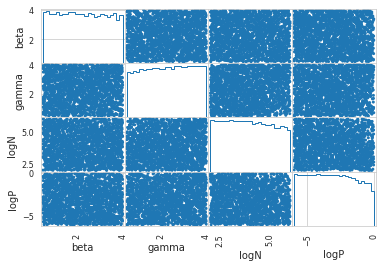

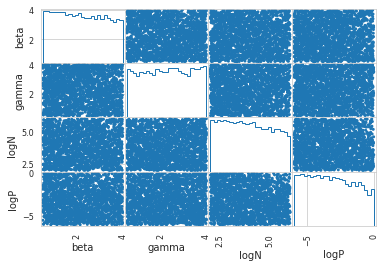

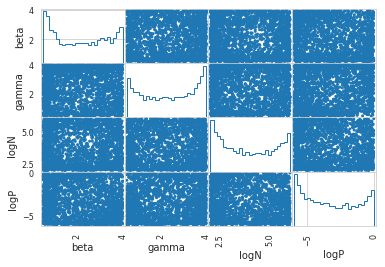

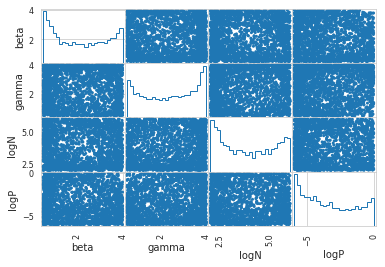

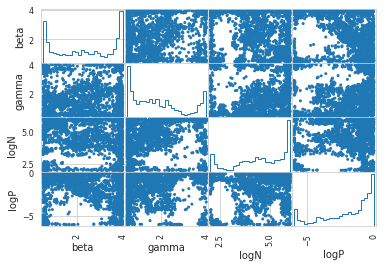

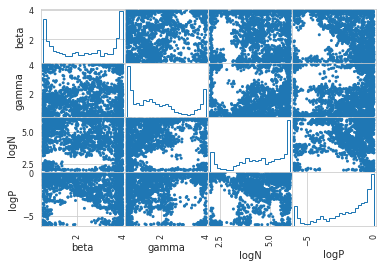

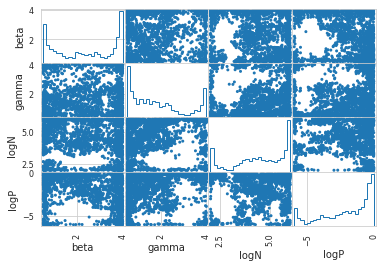

In [9]:
xInfo = pandas.DataFrame( {  'Name': x_name,
                             'Min' : x_min,
                             'Max' : x_max
                          } ).set_index('Name')
                          
xInit = init_historyMatching_poissonGlmBasis( xInfo,
                                              yref, 
                                              sir_taoLeap_getIncidenceSampled,
                                              jobId,
                                              hmParams
                                             )

print( xInit.head() )  # Quickly check how the output looks like

The call to our history matching initializer generates a directory containing history matching partial/diagnostic data. The name of the directory is given by the `jobId` parameter defined above, followed by a timestamp. The initializer also changes the current directory to main subdirectory in the newly created tree structure.

In [10]:
!pwd

!ls -R ..

/home/rnunez/.conda/envs/phylomodels_v3002/lib/python3.7/site-packages/calibration_historyMatching_sir_results--20191118-214110/main
..:
iter0  iter1  iter2  iter3  iter4  iter5  iter6  iter7	iter8  iter9  main

../iter0:
Cuts

../iter0/Cuts:
history_matching_cut

../iter0/Cuts/history_matching_cut:
GLM  GPR  Implausibility  history_matching_config.xlsx

../iter0/Cuts/history_matching_cut/GLM:
'GLM Predicted vs Actual.pdf'   QQ.pdf			 model.json
'GLM expId 0.pdf'	        deviance_redisuals.pdf	 params.p
 PairwiseResults	        fitted_vs_observed.pdf	 pearson_residuals.pdf

../iter0/Cuts/history_matching_cut/GLM/PairwiseResults:
beta-gamma.pdf	beta-logP.pdf	gamma-logP.pdf
beta-logN.pdf	gamma-logN.pdf	logN-logP.pdf

../iter0/Cuts/history_matching_cut/GPR:
PairwiseResults  gpr.pdf	model.json
emulation.pdf	 histogram.pdf	model_with_test_data.json

../iter0/Cuts/history_matching_cut/GPR/PairwiseResults:
beta-gamma.pdf	beta-logP.pdf	gamma-logP.pdf
beta-logN.pdf	gamma-logN.pdf	logN-logP.pdf


We can retrieve, for example, a summary of the history matching progression (as saved in `history.txt`)

In [11]:
!cat history.txt

Iteration  	  Rejection  	 Selected 	 Time (s) 
           	  Rate (%)   	 Feature  	          

    1		4.5776		sum_x		183.95
    2		9.9344		x_16		175.54
    3		9.7540		x_4		191.02
    4		53.1630		x_5		201.74
    5		55.6368		x_10		203.94
    6		56.2797		x_3		226.01
    7		98.7641		x_7		378.67
    8		98.7463		x_12		220.01
    9		98.7754		x_18		221.05
    10		99.8151		x_8		435.70


### Calibration

We can run a parameter sweep on the sets of parameters rendered by history matching to actually find the ones that better reproduce the observation data (i.e., trajectory selection).

In [12]:
xHat = cal_parameterSweep( xInfo, 
                           xInit, 
                           yref, 
                           sir_taoLeap_getIncidenceSampled, 
                           calParams )

print( xHat.head() )

           beta     gamma      logN      logP   i0   r0  nDays  cost  trial  \
52048  3.222832  2.062338  4.676891 -1.839333  5.0  0.0   20.0  2.05     25   
67103  3.080502  1.782516  5.124609 -2.343559  5.0  0.0   20.0  2.15     33   
71353  2.079193  0.839939  4.262094 -1.558689  5.0  0.0   20.0  2.15     35   
78313  1.937013  0.611347  4.161274 -1.479840  5.0  0.0   20.0  2.15     38   
70342  3.117320  2.086993  4.680436 -1.763751  5.0  0.0   20.0  2.20     34   

       i_0  ...  i_10  i_11  i_12  i_13  i_14  i_15  i_16  i_17  i_18  i_19  
52048  0.0  ...  17.0   7.0   4.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0  
67103  0.0  ...  21.0   4.0   5.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
71353  0.0  ...  15.0  11.0   9.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
78313  0.0  ...  15.0   9.0   2.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0  
70342  0.0  ...  25.0  14.0   4.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 29 columns]


### Results

#### Summary

In [13]:
print( "Ground truth:" )
print( "  beta  = ", "{:.2f}".format( xref["beta" ][0] ) )
print( "  gamma = ", "{:.2f}".format( xref["gamma"][0] ) )
print( "  N     = ", "{:.2f}".format( xref["N"].iloc[0] ) )
print( "  p     = ", "{:.2f}".format( xref["p"].iloc[0] ) )
print( "\n" )

Ground truth:
  beta  =  2.20
  gamma =  1.00
  N     =  10000.00
  p     =  0.05




In [14]:
# Set threshold for analysis
threshold = 0.005  # Analyze top % of solutions
nThreshold = round( threshold*len(xHat) )
nSolutions = 10    # Number of solutions to report

# Extract subset of relevant solutions
xHat_subset = xHat.iloc[:nThreshold][["beta","gamma","logN","logP","cost"]].copy()
xHat_subset["N"] = 10**xHat_subset["logN"]
xHat_subset["p"] = 10**xHat_subset["logP"]
xHat_subset = xHat_subset.drop(columns=["logN", "logP"])

# List top solutions
print( "Top ", nSolutions, " solutions:" )
print( xHat_subset.head(n=nSolutions) )

# List most-repeated solutions in subset defined by threshold
topSolutions = xHat_subset.groupby(["beta","gamma","N","p"]).count()
print( "\n" )
print( "Most repeated solutions in top ", nThreshold, ":" )
print(topSolutions.sort_values(by=["cost"], ascending=False).head(n=10))
print( "\n" )

Top  10  solutions:
           beta     gamma  cost              N         p
52048  3.222832  2.062338  2.05   47521.627460  0.014477
67103  3.080502  1.782516  2.15  133232.099509  0.004534
71353  2.079193  0.839939  2.15   18284.957305  0.027626
78313  1.937013  0.611347  2.15   14496.870730  0.033125
70342  3.117320  2.086993  2.20   47911.096527  0.017229
70400  3.067097  1.754704  2.25   33414.087322  0.018458
32760  3.098889  1.848605  2.35   34443.244586  0.020276
77383  2.079193  0.839939  2.40   18284.957305  0.027626
93463  2.079193  0.839939  2.40   18284.957305  0.027626
3854   2.665653  1.289875  2.45   22153.584592  0.026687


Most repeated solutions in top  502 :
                                         cost
beta     gamma    N            p             
2.940198 1.614310 40349.557827 0.012904    15
3.098889 1.848605 34443.244586 0.020276    15
2.911461 1.713709 31733.703716 0.021637    15
2.814579 1.582925 32702.819946 0.016387    14
3.067097 1.754704 33414.087322 0.0184

#### History matching output

History matching returns a set of candidate points to be evaluated by the calibration method. Those points are expected to significantly reduce the initial parameter space.

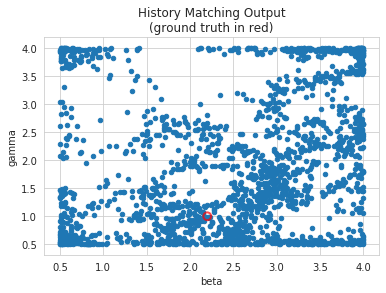

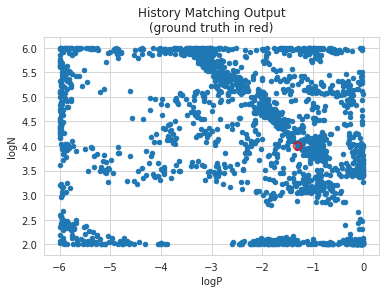

In [15]:
titleString = "History Matching Output\n(ground truth in red)"
xInit.plot.scatter( x     = "beta", 
                   y     = "gamma",
                   title = titleString,
                   grid  = True
                     )
plt.scatter( xref["beta"],          # Superimpose the actual solution
             xref["gamma"], 
             marker="o" ,
             s = 60,
             linewidths =2,
             color="r", 
             facecolors="none",
             alpha=0.7
            )

titleString = "History Matching Output\n(ground truth in red)"
xInit.plot.scatter( x     = "logP", 
                   y     = "logN",
                   title = titleString,
                   grid  = True
                     )
plt.scatter( numpy.log10( xref["p"] ),  # Superimpose the actual solution
             numpy.log10( xref["N"] ), 
             marker="o" ,
             s = 60,
             linewidths =2,
             color="r", 
             facecolors="none",
             alpha=0.7
            )

#### Parameter sweep output

Through parameter sweep we compute error metrics on multiple model calls with each parameter set. The results may be seen as an approximated pseudo-likelihood function on the parameter space.

In the figure below, the darker the point, the better it approximates the observation data.

In [16]:
# Plot beta vs gamma
titleString = "Parameter Sweep Output\n(darker is better; ground truth in red)"
xHatReverseOrder = xHat.sort_values( by=["cost"], ascending=False ) # This sorts 
                # the data for the scatter plot rendering engine. With data sorted
                # in this way, dots with lower cost (i.e., better) are rendered
                # at last, ensuring that they are more visible
xHatReverseOrder.plot.scatter( x        = "beta", 
                               y        = "gamma", 
                               c        = numpy.log10( xHatReverseOrder["cost"] ), 
                               colormap = "bone",
                               title = titleString,
                               grid     = True
                              )
f = plt.gcf(); cax = f.get_axes()[1]; cax.set_ylabel("Log10(cost)")
plt.scatter( xref["beta"],          # Superimpose the actual solution
             xref["gamma"], 
             marker="o" ,
             linewidths =2,
             s = 60,
             color="r", 
             facecolors="none",
             alpha=0.8
            )

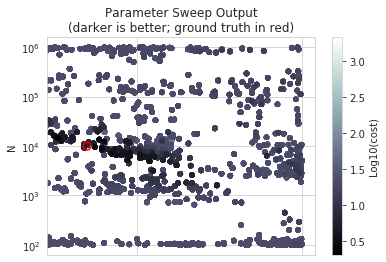

In [23]:
# Plot N vs p
xHat["N"] = 10**xHat["logN"]
xHat["p"] = 10**xHat["logP"]
titleString = "Parameter Sweep Output\n(darker is better; ground truth in red)"
xHatReverseOrder = xHat.sort_values( by=["cost"], ascending=False ) 
xHatReverseOrder.plot.scatter( x        = "p", 
                               y        = "N", 
                               c        = numpy.log10( xHatReverseOrder["cost"] ), 
                               colormap = "bone",
                               title = titleString,
                               grid     = True
                              )
f = plt.gcf(); cax = f.get_axes()[1]; cax.set_ylabel("Log10(cost)")
plt.scatter( xref["p"],          # Superimpose the actual solution
             xref["N"], 
             marker="o" ,
             linewidths =2,
             s = 60,
             color="r", 
             facecolors="none",
             alpha=0.8
            )
plt.xscale("log")
plt.yscale("log")

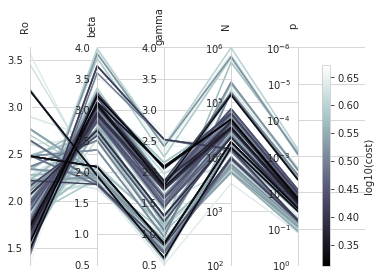

In [19]:
# Plot all relevant parameters, and Ro
xHat_subset["Ro"] = xHat_subset["beta"] / xHat_subset["gamma"]

RoMin = 0.98 * xHat_subset["Ro"].min()
RoMax = 1.02 * xHat_subset["Ro"].max()
x_name_pcp    = [   "Ro",    "beta",  "gamma",    "N",   "p" ]
x_min_pcp     = [  RoMin,  x_min[0],  x_min[1],  Nmin,  Pmin ]
x_max_pcp     = [  RoMax,  x_max[0],  x_max[1],  Nmax,  Pmax ]
x_logaxis_pcp = [  False,     False,     False,  True,  True ]
x_revaxis_pcp = [  False,     False,     False, False,  True ]

xInfo_logaxisrev = pandas.DataFrame( {  "Name"    : x_name_pcp,
                                        "Min"     : x_min_pcp,
                                        "Max"     : x_max_pcp,
                                        "logaxis" : x_logaxis_pcp,
                                        "revaxis" : x_revaxis_pcp
                                     } )

parallelCoordinates( xHat_subset, xInfo_logaxisrev, c="cost", clog=True)

#### Incidence curves

We can further verify the quality of the results by checking how well the incidence obtained by the best parameter sets (and their multiple realizations) fits the observations.

Curve # 1 :	 [beta, gamma, N, p] = [3.22, 2.06, 47521.63, 0.01]
Curve # 2 :	 [beta, gamma, N, p] = [3.08, 1.78, 133232.10, 0.00]
Curve # 3 :	 [beta, gamma, N, p] = [2.08, 0.84, 18284.96, 0.03]
Curve # 4 :	 [beta, gamma, N, p] = [1.94, 0.61, 14496.87, 0.03]
Curve # 5 :	 [beta, gamma, N, p] = [3.12, 2.09, 47911.10, 0.02]
Curve # 6 :	 [beta, gamma, N, p] = [3.07, 1.75, 33414.09, 0.02]
Curve # 7 :	 [beta, gamma, N, p] = [3.10, 1.85, 34443.24, 0.02]
Curve # 8 :	 [beta, gamma, N, p] = [2.08, 0.84, 18284.96, 0.03]
Curve # 9 :	 [beta, gamma, N, p] = [2.08, 0.84, 18284.96, 0.03]
Curve # 10 :	 [beta, gamma, N, p] = [2.67, 1.29, 22153.58, 0.03]


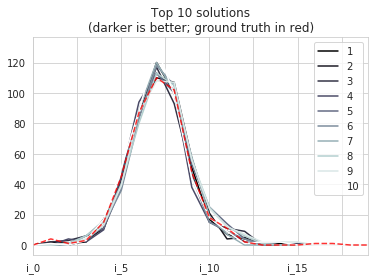

In [25]:
# Select the number of incidence curves to plot 
# and extract them from the solution dataframe
nTop = 10
lastColumn = xHat.columns[-3]
topSolutions = xHat.loc[:,"i_0":lastColumn].iloc[0:nTop].copy()


# Plot the curves
titleString = "Top " + str(nTop) \
              + " solutions\n(darker is better; ground truth in red)"
legendArray = []
for i in range(0,nTop):
    legendArray.append( "[beta, gamma, N, p] = ["                    \
                        + "{:.2f}".format( xHat["beta" ].iloc[i] )   \
                        + ", "                                       \
                        + "{:.2f}".format( xHat["gamma"].iloc[i] )   \
                        + ", "                                       \
                        + "{:.2f}".format( xHat["N"].iloc[i] )       \
                        + ", "                                       \
                        + "{:.2f}".format( xHat["p"].iloc[i] )       \
                        + "]"
                       )
colorScale = xHat["cost"].iloc[0:nTop].values
warnings.filterwarnings("ignore")  # Temporarily supress matplotlib warnings
                                   # generated within pandas plotting process
ax = topSolutions.transpose().plot( title    = titleString,
                                    c        = colorScale,
                                    colormap = "bone", 
                                    grid     = True
                                   )
warnings.filterwarnings("default") # Restore warnings
#ax.legend(legendArray)
ax.legend( range(1,nTop+1) )
yref.transpose().plot( ax     = ax,       # Superimpose grount truth
                       style  = "r--",
                       alpha  = 0.8,
                       legend = False,
                       grid   = True
                      )

# Print legend
i = 1
for line in legendArray:
    print( "Curve #", i, ":\t", line )
    i = i + 1